## **Importação das bibliotecas e datasets e criação das funções**

In [31]:
# %pip install ipykernel --break-system-packages
# %pip install scikit-learn --break-system-packages
# %pip install matplotlib --break-system-packages
# %pip install keras --break-system-packages
# %pip install tensorflow --break-system-packages
# %pip install pandas --break-system-packages
# %pip install plotly --break-system-packages
# %pip install seaborn --break-system-packages
# %pip install nbformat --break-system-packages
# %pip install keras --break-system-packages
# %pip install pswarm
# !pip install statsmodels

In [32]:
import json
import os
import sys
import io
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.initializers import GlorotUniform, Orthogonal
from keras.layers import Dense,Dropout,SimpleRNN,LSTM #Biblioteca para deep learning
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Configurar a seed para o Python, NumPy e TensorFlow
SEED = 42  # valor fixo que será utilizado como seed

# Seed para o Python
random.seed(SEED)

# Seed para o NumPy (usado para operações de matriz e aleatoriedade fora do TensorFlow)
np.random.seed(SEED)

# Seed para o TensorFlow
tf.random.set_seed(SEED)

In [33]:
base_path = './dataset/'
time_base = 'days'
agrupamento = "3"
dataset_type_du = f"{agrupamento}_days_duas_unas"
#validation_method = 'split'

In [34]:
# Carregar o arquivo JSON
with open('config_pso.json') as f:
    config = json.load(f)

In [35]:
# Cria um diretório específico se não existir
diretorio_pesos_teste_1 = f"Resultados_PSO/pso_du/{agrupamento}_days/pesos/teste_1"
os.makedirs(diretorio_pesos_teste_1, exist_ok=True)

diretorio_pesos_teste_3 = f"Resultados_PSO/pso_du/{agrupamento}_days/pesos/teste_3"
os.makedirs(diretorio_pesos_teste_3, exist_ok=True)

diretorio_avaliacao_teste_0 = f"Resultados_PSO/pso_du/{agrupamento}_days/avaliacao_testes/teste_0"
os.makedirs(diretorio_avaliacao_teste_0, exist_ok=True)

diretorio_avaliacao_teste_1 = f"Resultados_PSO/pso_du/{agrupamento}_days/avaliacao_testes/teste_1"
os.makedirs(diretorio_avaliacao_teste_1, exist_ok=True)

diretorio_avaliacao_teste_2 = f"Resultados_PSO/pso_du/{agrupamento}_days/avaliacao_testes/teste_2"
os.makedirs(diretorio_avaliacao_teste_2, exist_ok=True)

diretorio_avaliacao_teste_3 = f"Resultados_PSO/pso_du/{agrupamento}_days/avaliacao_testes/teste_3"
os.makedirs(diretorio_avaliacao_teste_3, exist_ok=True)

diretorio_avaliacao_teste_4 = f"Resultados_PSO/pso_du/{agrupamento}_days/avaliacao_testes/teste_4"
os.makedirs(diretorio_avaliacao_teste_4, exist_ok=True)

diretorio_resultados_ensemble = f"Resultados_PSO/pso_du/{agrupamento}_days/Resultados_Ensemble"
os.makedirs(diretorio_avaliacao_teste_4, exist_ok=True)


In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))  # Padronização dos dados

duas_unas_dataset = f'{base_path}duas_unas/{time_base}/grouped_{agrupamento}_{time_base}.csv'
prataI_dataset = f'{base_path}outras_unidades/{time_base}/PRATA_I_{agrupamento}_{time_base}.csv'
prataII_dataset = f'{base_path}outras_unidades/{time_base}/PRATA_II_{agrupamento}_{time_base}.csv'
prataIII_dataset = f'{base_path}outras_unidades/{time_base}/PRATA_III_{agrupamento}_{time_base}.csv'
pirapama_dataset = f'{base_path}outras_unidades/pirapama/Pirapama_{agrupamento}_{time_base}.csv'
volume_du_dataset = f'{base_path}volume/volume_grouped_{agrupamento}_{time_base}.csv'
emulado_dataset = f'{base_path}duas_unas/emulado/duas_unas_emulados.csv'

In [37]:
# transformando CSV em DataFrame
duas_unas_df = pd.read_csv(duas_unas_dataset)  # Transformação em dataset
prataI_df = pd.read_csv(prataI_dataset)  # Transformação em dataset
prataII_df = pd.read_csv(prataII_dataset)  # Transformação em dataset
prataIII_df = pd.read_csv(prataIII_dataset)  # Transformação em dataset
pirapama_df = pd.read_csv(pirapama_dataset)  # Transformação em dataset
volume_du_df = pd.read_csv(volume_du_dataset)  # Transformação em dataset
emulado_df = pd.read_csv(emulado_dataset)  # Transformação em dataset

In [38]:
validation_interval = config['datasets'][dataset_type_du]['timesteps'] + config['datasets'][dataset_type_du]['output_horizon'] # Definição da parcela dos dados que serão retiradas do treinamento/teste para validação
horizonte = config['datasets'][dataset_type_du]['output_horizon']

indices_to_validate = duas_unas_df.index[-validation_interval:].tolist()  # Obtenção dos índices dos dados de validação

datasets = [pirapama_df, prataI_df, prataII_df, prataIII_df, duas_unas_df, volume_du_df, emulado_df]  # df1, df2, etc., são os dataframes

# Aplicar MinMaxScaler para cada dataset individualmente
scaled_datasets = []
scalers = []
for i, df in enumerate(datasets):
    # Garantir que 'timestamp' é do tipo datetime e já está configurado corretamente como índice
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values(by='timestamp')
        df.set_index('timestamp', inplace=True)

    # Aplicar o scaler apenas nas colunas numéricas
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.select_dtypes(include=[float, int]))  # Apenas colunas numéricas
    scaled_df = pd.DataFrame(scaled_data, columns=df.select_dtypes(include=[float, int]).columns, index=df.index)
    
    # Adicionar o DataFrame escalado à lista
    scaled_datasets.append(scaled_df)
    scalers.append(scaler)  # Salvar o scaler específico para este dataset

duas_unas_validation_scaled = scaled_datasets[4].tail(validation_interval)  # Criação do dataset de validação

# Define o número de linhas a serem removidas
Xis = len(indices_to_validate)
duas_unas_df_scaled = scaled_datasets[4].iloc[:-Xis]
volume_du_df_scaled = scaled_datasets[5].iloc[:(duas_unas_df_scaled.shape[0])]
volume_du_df_validation = scaled_datasets[5].iloc[(duas_unas_df_scaled.shape[0]):]
print(volume_du_df_scaled.shape)
print(volume_du_df_validation.shape)

scaled_datasets[4] = duas_unas_df_scaled
scaled_datasets[5] = volume_du_df_scaled

print(f,"duas_unas para treinamento e teste:", scaled_datasets[4])
print(f,"duas_unas para validação:", duas_unas_validation_scaled)

print(f,"volume para treinamento e teste:", scaled_datasets[5])
print(f,"volume para validação:", volume_du_df_validation)


(73, 2)
(31, 2)
<_io.TextIOWrapper name='config_pso.json' mode='r' encoding='cp1252'> duas_unas para treinamento e teste:             kWh fornecido
timestamp                
2023-10-01       0.000000
2023-10-04       0.345662
2023-10-07       0.747771
2023-10-10       0.914409
2023-10-13       0.913913
...                   ...
2024-04-22       0.912180
2024-04-25       0.903549
2024-04-28       0.896600
2024-05-01       0.839799
2024-05-04       0.878018

[73 rows x 1 columns]
<_io.TextIOWrapper name='config_pso.json' mode='r' encoding='cp1252'> duas_unas para validação:             kWh fornecido
timestamp                
2024-05-07       0.817071
2024-05-10       0.831403
2024-05-13       0.835162
2024-05-16       0.768227
2024-05-19       0.960820
2024-05-22       0.946822
2024-05-25       0.954853
2024-05-28       0.956314
2024-05-31       0.950227
2024-06-03       0.947856
2024-06-06       0.949203
2024-06-09       0.963447
2024-06-12       0.964052
2024-06-15       0.972923
2024-

In [39]:
def save_function_output(func, *args, output_file, output_dir, **kwargs):
    # Redireciona stdout para capturar os prints
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout
    
    try:
        # Executa a função e captura sua saída
        func(*args, **kwargs)
    finally:
        # Restaura stdout e captura a saída
        sys.stdout = old_stdout
        output = new_stdout.getvalue()
        
        # Cria o diretório se não existir
        os.makedirs(output_dir, exist_ok=True)
        
        # Caminho completo para o arquivo de saída
        save_path = os.path.join(output_dir, output_file)
        
        # Salva a saída em um arquivo
        with open(save_path, 'w') as f:
            f.write(output)
        print(f"Output salvo em: {save_path}")

In [40]:
def identify_peaks_and_valleys(y_test):
    # Converte y_test em um tensor
    #y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
    # Inicializa pesos como um tensor de 1s do mesmo formato
    weights = tf.ones(tf.shape(y_test), dtype=tf.float32)

    # Condicional para verificar se y_test tem pelo menos 3 elementos
    mask = tf.size(y_test) < 3

    # Função para processar picos e vales
    def process_peaks_and_valleys():
        # Certifique-se de que y_test é do tipo float32
        y_test_float = tf.cast(y_test, tf.float32)

        # Obtém os índices de picos e vales para elementos intermediários
        # Corrigido: use tf.expand_dims para garantir que o primeiro elemento tenha o formato correto
        y_test_prev = tf.concat([tf.expand_dims(y_test_float[0], axis=0), y_test_float[:-1]], axis=0)  # Adiciona o primeiro elemento como anterior
        y_test_next = tf.concat([y_test_float[1:], tf.expand_dims(y_test_float[-1], axis=0)], axis=0)  # Adiciona o último elemento como próximo

        # Define picos e vales para os elementos intermediários
        peaks = tf.where((y_test_float > y_test_prev) & (y_test_float > y_test_next))
        valleys = tf.where((y_test_float < y_test_prev) & (y_test_float < y_test_next))

        # Atualiza os pesos para picos e vales intermediários
        weights_updated = tf.tensor_scatter_nd_update(weights, peaks, tf.fill(tf.shape(peaks)[:1], 3.0))
        weights_updated = tf.tensor_scatter_nd_update(weights_updated, valleys, tf.fill(tf.shape(valleys)[:1], 3.0))

        return weights_updated

    # Condicional para executar a função de processamento se y_test tiver 3 ou mais elementos
    weights = tf.cond(mask, lambda: weights, process_peaks_and_valleys)

    return weights


In [41]:
# Função WMAE ajustada com pesos para picos e vales
def wmae(y_test, y_pred):
    # Convertendo y_test e y_pred para float32
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    #y_test = tf.squeeze(y_test)
    #y_pred = tf.squeeze(y_pred)

    weights = identify_peaks_and_valleys(y_test)

    return (tf.reduce_sum(weights * tf.abs(y_test - y_pred)) / tf.reduce_sum(weights))

In [42]:
def wmse(y_test, y_pred):
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    weights = identify_peaks_and_valleys(y_test)

    wmse_value = (tf.reduce_sum(weights * tf.square(y_test - y_pred)) / tf.reduce_sum(weights))

    return wmse_value

In [43]:

def create_and_train_model(config, dataset_type, X, y, validation_method, k, tt_rate):
    
    model = Sequential()

    for _ in range(int(config['datasets'][dataset_type]['layers'])):
        model.add(LSTM(int(config['datasets'][dataset_type]['neurons']),
                        #kernel_initializer=GlorotUniform(),  # Inicializador para os pesos
                        #recurrent_initializer=GlorotUniform(),  # Inicializador para os pesos recorrentes
                        #bias_initializer=GlorotUniform(),  # Inicializador para os bias
                        return_sequences=True if _ < int(config['datasets'][dataset_type]["layers"]) - 1 else False, input_shape=(X.shape[1], 1)))

        model.add(Dropout(config['datasets'][dataset_type]['dropout']))

    model.add(Dense(config['datasets'][dataset_type]['output_horizon'], 
                        #kernel_initializer=GlorotUniform(),  # Inicializador para os pesos
                        #bias_initializer=GlorotUniform(),  # Inicializador para os biases
                        activation=config['datasets'][dataset_type]['activation']))

    model.summary()

    # Configurar o otimizador
    optimizer = config['datasets'][dataset_type]['optimizer']
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=config['datasets'][dataset_type]['learning_rate'])
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=config['datasets'][dataset_type]['learning_rate'])
    else:
        opt = SGD(learning_rate=config['datasets'][dataset_type]['learning_rate'])

    # Configurar a função de perda
    loss_function = config['datasets'][dataset_type]["loss_function"]

    if loss_function == "wmae":
        loss = wmae
    elif loss_function == "wmse":
        loss = wmse

    model.compile(optimizer=opt, loss=loss)

    early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=config['datasets'][dataset_type]['patience'], restore_best_weights=True)

    # Aplicar o método de validação
    if validation_method == 'split':
        # Usar validação por divisão
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=tt_rate, random_state=42)
        
        print(f"X_test shape:",X_val.shape)
        print(f"y_test shape:",y_val.shape)
        
        history = model.fit(X_train, y_train, batch_size=config['datasets'][dataset_type]['batch_size'], epochs=100000, validation_data=(X_val, y_val), 
                        callbacks=[early_stopping])
        
        # Ajuste do gráfico para começar em 1
        epochs_range = range(1, len(history.history['loss']) + 1)
        
        plt.plot(epochs_range, history.history['loss'], label='Loss de Treinamento')
        plt.plot(epochs_range, history.history['val_loss'], label='Loss de Validação')
        plt.xlabel('Épocas')
        plt.ylabel('Perda')
        plt.legend()
        plt.show()

    return model, X_val, y_val

In [44]:
def create_dataset(data, time_step, output_steps):  # Função para construção do dataset
    X= []  # Criação das listas
    y = []
    for i in range(len(data) - time_step - output_steps + 1):  # Loop
        X.append(data.iloc[i:(i + time_step), 0])  # Construção do dataset com `.iloc`
        y.append(data.iloc[(i + time_step):(i + time_step + output_steps), 0])
    
    print("X shape", np.array(X).shape)
    print("y shape", np.array(y).shape)
    return np.array(X), np.array(y)

In [45]:
def concatenate_selected_datasets(datasets, indices):
    
    # Selecionar os datasets pelos índices fornecidos
    selected_datasets = [datasets[i] for i in indices]
    
    # Concatenar os datasets selecionados
    concatenated_df = pd.concat(selected_datasets, ignore_index=True)
    
    # Resetar o índice para uma sequência numérica
    concatenated_df.reset_index(drop=True, inplace=True)
    
    return concatenated_df

In [46]:
def create_dataset_multivar(data, time_step, output_steps):
    X, y = [], []
    for i in range(len(data) - time_step - output_steps + 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[(i + time_step):(i + time_step + output_steps), 0])
    return np.array(X), np.array(y)

In [47]:
# Carregar os pesos salvos
def carregar_pesos(arquivo_pesos_camada):

  with np.load(arquivo_pesos_camada) as data:
      W = data['arr_0']
      U = data['arr_1']
      b = data['arr_2']
      # Os pesos podem ter mais de um conjunto, então você deve garantir que a ordem e o número estejam corretos.
      loaded_weights = [W, U, b]
      print(W.shape)
      print(U.shape)
      print(b.shape)
  return loaded_weights

In [48]:
def carregar_e_aplicar_pesos(lstm_model, caminho_LSTM1, caminho_LSTM2, caminho_LSTM3):
    
    pesos_LSTM1_t1_carregado = carregar_pesos(caminho_LSTM1)
    pesos_LSTM2_t1_carregado = carregar_pesos(caminho_LSTM2)
    #pesos_LSTM3_t1_carregado = carregar_pesos(caminho_LSTM3)

    # Aplicar os pesos carregados à camada LSTM
    lstm_model.get_layer(index=0).set_weights(pesos_LSTM1_t1_carregado)
    lstm_model.get_layer(index=2).set_weights(pesos_LSTM2_t1_carregado)
    #lstm_model.get_layer(index=4).set_weights(pesos_LSTM3_t1_carregado)

In [49]:
# Congela as três primeiras camadas LSTM e suas respectivas camadas dropout subsequentes
def congelar_camadas(lstm_model):
#lstm_model_treinado.layers[2] - Mostra o tipo da camada 2 do modelo
    lstm_model.layers[0].trainable = False
    lstm_model.layers[2].trainable = False
    #lstm_model.layers[4].trainable = False
    print(f"LSTM 1 treinable: ",lstm_model.layers[0].trainable)
    print(f"LSTM 2 treinable: ",lstm_model.layers[2].trainable)
    #print(f"LSTM 3 treinable: ",lstm_model.layers[4].trainable)

In [50]:
# Descongela as duas primeiras camadas LSTM e suas respectivas camadas dropout subsequentes
def descongelar_camadas(lstm_model):
    #lstm_model_treinado.layers[2] - Mostra o tipo da camada 2 do modelo
    lstm_model.layers[0].trainable = True
    lstm_model.layers[2].trainable = True
    #lstm_model.layers[4].trainable = True
    print(f"LSTM 1 treinable: ",lstm_model.layers[0].trainable)
    print(f"LSTM 2 treinable: ",lstm_model.layers[2].trainable)
    #print(f"LSTM 3 treinable: ",lstm_model.layers[4].trainable)

In [51]:
# Automatizar os splits de treino/teste
current_filename = None
resultados = []  # Para armazenar os resultados de cada execução
def salvar_resultados(mae, mse, rmse, mape, acuracia_2, acuracia_5, acuracia_10, err_perc_acum_ter_mes, err_perc_acum_seg_mes, err_perc_acum_pri_mes, err_perc_acum_90dias, err_perc_acum_60dias, err_perc_acum_30dias, diretorio, validation):
    global current_filename, resultados
    
    # Se o nome do arquivo mudou, salvar os resultados e reiniciar a lista
    if current_filename != diretorio:
        # Atualiza o nome do arquivo atual e reinicia a lista de resultados
        current_filename = diretorio
        resultados = []  # Reinicia a lista de resultados
    
    # Armazenar os resultados
    resultados.append({
        'validation': validation,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
        'accuracy 2%': acuracia_2,
        'accuracy 5%': acuracia_5,
        'accuracy 10%': acuracia_10,
        'Erro percentual acumulado 30 dias': err_perc_acum_30dias,
        'Erro percentual acumulado 60 dias': err_perc_acum_60dias,
        'Erro percentual acumulado 90 dias': err_perc_acum_90dias,
        'Erro percentual acumulado 1º mês': err_perc_acum_pri_mes,
        'Erro percentual acumulado 2º mês': err_perc_acum_seg_mes,
        'Erro percentual acumulado 3º mês': err_perc_acum_ter_mes
         
        
    })
            
    # Salvar os resultados em um arquivo CSV
    results_df = pd.DataFrame(resultados)
    results_df.to_csv(f'{diretorio}/results.csv', index=False)
    print('Terminada sequencia de testes')

In [52]:
def avaliacao_multistep(janela_real, janela_prevista, diretorio, validation):

    
    if len(janela_real) != len(janela_prevista):
        raise ValueError("As janelas reais e previstas devem ter o mesmo comprimento.")
    
    # Converte para arrays 1D, se necessário
    janela_real = np.array(janela_real).reshape(-1)
    janela_prevista = np.array(janela_prevista).reshape(-1)
    
    # print(janela_real)
    # print(" ")
    # print(janela_prevista)
    # print(" ")

    mae_med = 0
    mse_med = 0
    rmse_med = 0
    mape_med = 0
    acuracia_med = 0

    mae = round(mean_absolute_error(janela_real, janela_prevista), 3) # Arredondamento com três casas decimais
    print("MAE(Erro absoluto médio) Score of LSTM model = ",mae)
    print(" ")

    mse = round(mean_squared_error(janela_real, janela_prevista), 3)
    print("MSE(Erro quadrático médio) Score of LSTM model = ",mse)
    print(" ")
            
    rmse = round(np.sqrt(mse), 3)
    print("RMSE(Raiz do erro quadrático médio) Score of LSTM model = ",rmse)
    print(" ")

    mape = round(mean_absolute_percentage_error(janela_real, janela_prevista), 2)
    print("MAPE(Erro percentual médio absoluto) Score of LSTM model = ",mape)
    print(" ")
            
    ### Cálculo da ACURÁCIA ###
            
    # Calcula a diferença percentual
    diferencas_percentuais = np.abs((janela_real - janela_prevista) / janela_real)

    # Calcula a acurácia com a contagem de acertos entre 0 e 100%
    acuracia_2 = round(100 * (np.sum(diferencas_percentuais <= 0.02) / len(janela_real)), 2)
    acuracia_5 = round(100 * (np.sum(diferencas_percentuais <= 0.05) / len(janela_real)), 2)
    acuracia_10 = round(100 * (np.sum(diferencas_percentuais <= 0.1) / len(janela_real)), 2)

            
    print("2% Accuracy Score of LSTM model = ",acuracia_2)
    print("5% Accuracy Score of LSTM model = ",acuracia_5)
    print("10% Accuracy Score of LSTM model = ",acuracia_10)
    print(" ")
    
    if agrupamento == '1':
        h_1mes = 30
        h_2mes = 60
        
    elif agrupamento == '3':
        h_1mes = 10
        h_2mes = 20

    else:
        h_1mes = 4
        h_2mes = 8

    acumulado_1mes_real = janela_real[:h_1mes].sum()
    # print("acumulado_1mes_real", acumulado_1mes_real)
    acumulado_1e2mes_real = janela_real[:h_2mes].sum()
    # print("acumulado_1e2mes_real", acumulado_1e2mes_real)
    acumulado_1e2e3mes_real = janela_real[:].sum()
    # print("acumulado_1e2e3mes_real", acumulado_1e2e3mes_real)
    acumulado_2mes_real = janela_real[h_1mes:h_2mes].sum()
    # print("acumulado_2mes_real", acumulado_2mes_real)
    acumulado_3mes_real = janela_real[h_2mes:].sum()
    # print("acumulado_3mes_real", acumulado_3mes_real)

    acumulado_1mes_pred = janela_prevista[:h_1mes].sum()
    # print("acumulado_1mes_pred", acumulado_1mes_pred)
    acumulado_1e2mes_pred = janela_prevista[:h_2mes].sum()
    # print("acumulado_1e2mes_pred", acumulado_1e2mes_pred)
    acumulado_1e2e3mes_pred = janela_prevista[:].sum()
    # print("acumulado_1e2e3mes_pred", acumulado_1e2e3mes_pred)
    acumulado_2mes_pred = janela_prevista[h_1mes:h_2mes].sum()
    # print("acumulado_2mes_pred", acumulado_2mes_pred)
    acumulado_3mes_pred = janela_prevista[h_2mes:].sum()
    # print("acumulado_3mes_pred", acumulado_3mes_pred)
    
    err_perc_acum_30dias = round(((abs(acumulado_1mes_real-acumulado_1mes_pred))/acumulado_1mes_real)*100, 2)
    err_perc_acum_60dias = round(((abs(acumulado_1e2mes_real-acumulado_1e2mes_pred))/acumulado_1e2mes_real)*100, 2)
    err_perc_acum_90dias = round(((abs(acumulado_1e2e3mes_real-acumulado_1e2e3mes_pred))/acumulado_1e2e3mes_real)*100, 2)
    err_perc_acum_pri_mes = round(((abs(acumulado_1mes_real-acumulado_1mes_pred))/acumulado_1mes_real)*100, 2)
    err_perc_acum_seg_mes = round(((abs(acumulado_2mes_real-acumulado_2mes_pred))/acumulado_2mes_real)*100, 2)
    err_perc_acum_ter_mes = round(((abs(acumulado_3mes_real-acumulado_3mes_pred))/acumulado_3mes_real)*100, 2)

    print("Erro %. acum 30 dias:", err_perc_acum_30dias,"%")
    print("Erro %. acum 60 dias:", err_perc_acum_60dias,"%")
    print("Erro %. acum 90 dias:", err_perc_acum_90dias,"%")
    print(" ")
    print("Erro %. acum 1º mês:", err_perc_acum_pri_mes,"%")
    print("Erro %. acum 2º mês:", err_perc_acum_seg_mes,"%")
    print("Erro %. acum 3º mês:", err_perc_acum_ter_mes,"%")
    
    salvar_resultados(mae, mse, rmse, mape, acuracia_2, acuracia_5, acuracia_10, err_perc_acum_ter_mes, err_perc_acum_seg_mes, err_perc_acum_pri_mes, err_perc_acum_90dias, err_perc_acum_60dias, err_perc_acum_30dias, diretorio, validation)
    
    return

In [53]:
def results(model, validation_dataset_scaled, validation_method, diretorio, validation):
    pred = model.predict(validation_dataset_scaled.iloc[0])
    y_pred_rescaled = scalers[4].inverse_transform(pred)
    y_pred_rescaled = y_pred_rescaled.reshape(-1)  # Converte para 1D, se necessário
    duas_unas_validation_rescaled = scalers[4].inverse_transform(validation_dataset_scaled[1:])

    plt.figure(figsize=(14,6))
    plt.plot(validation_dataset_scaled[1:].index, duas_unas_validation_rescaled, label="Original", color='blue')
    plt.plot(validation_dataset_scaled[1:].index, y_pred_rescaled, label="Predict", color='red')
    plt.yticks(np.arange(0,25000,step=5000))
    plt.title("DATASET TESTE")

        # Nome do arquivo incluindo a variável 'validation_method'
    file_name = f'prediction_plot_with_method_{validation_method}_{validation}.png'

    # Caminho completo para salvar o arquivo
    save_path = os.path.join(diretorio, file_name)

    # Salvar o plot
    plt.savefig(save_path)
    plt.show()
    
    
    #avaliacao_multistep(duas_unas_validation_rescaled, y_pred_rescaled, diretorio, validation)

    # Nome do arquivo incluindo a variável 'validation_method'
    output_file = f'avaliacao_with_method_{validation_method}_{validation}.txt'
    
    save_function_output(avaliacao_multistep, 
                        duas_unas_validation_rescaled, 
                        y_pred_rescaled,
                        diretorio,
                        validation, 
                        output_file = output_file, 
                        output_dir=diretorio)

In [54]:
from tensorflow.keras.initializers import HeNormal
def transfer_learning_model(config, model, diretorio_pesos, diretorio_resultados, teste, validation_method, k):
    
    # Salvamento dos pesos após primeiro treinamento
    pesos_treinamento = model.get_weights()
    pesos_LSTM1 = model.layers[0].get_weights()
    pesos_LSTM2 = model.layers[2].get_weights()
    pesos_LSTM3 = model.layers[4].get_weights()
    pesos_DENSE = model.layers[6].get_weights()

    # Salvar pesos de cada camada LSTM em arquivos .npz
    np.savez(os.path.join(diretorio_pesos, f'pesos_LSTM1_{teste}_{validation_method}_{k}.npz'), *pesos_LSTM1)
    np.savez(os.path.join(diretorio_pesos, f'pesos_LSTM2_{teste}_{validation_method}_{k}.npz'), *pesos_LSTM2)
    np.savez(os.path.join(diretorio_pesos, f'pesos_LSTM3_{teste}_{validation_method}_{k}.npz'), *pesos_LSTM3)
    np.savez(os.path.join(diretorio_pesos, f'pesos_DENSE_{teste}_{validation_method}_{k}.npz'), *pesos_DENSE)

    # Para salvar os pesos do modelo completo
    np.savez(os.path.join(diretorio_pesos, f'pesos_modelo_{teste}_{validation_method}_{k}.npz'), *pesos_treinamento)

    # # Carregar pesos do arquivo .npz
    # pesos_carregados_LSTM1 = np.load(os.path.join(diretorio, f'pesos_LSTM1_{teste}_{validation_method}.npz'))
    # pesos_carregados_LSTM2 = np.load(os.path.join(diretorio, f'pesos_LSTM2_{teste}_{validation_method}.npz'))
    # pesos_carregados_LSTM3 = np.load(os.path.join(diretorio, f'pesos_LSTM3_{teste}_{validation_method}.npz'))
    
    
    X, y = create_dataset(scaled_datasets[4], config['datasets'][dataset_type_du]['timesteps'], config['datasets'][dataset_type_du]['output_horizon'])
    X = X.reshape(X.shape[0], X.shape[1], 1)

    model_ft = Sequential()

    for _ in range(int(config['datasets'][dataset_type_du]['layers'])):
        model_ft.add(LSTM(int(config['datasets'][dataset_type_du]['neurons']),
                        #kernel_initializer=GlorotUniform(),  # Inicializador para os pesos
                        #recurrent_initializer=GlorotUniform(),  # Inicializador para os pesos recorrentes
                        #bias_initializer=GlorotUniform(),  # Inicializador para os bias
                        return_sequences=True if _ < int(config['datasets'][dataset_type_du]["layers"]) - 1 else False, input_shape=(X.shape[1], 1)))

        model_ft.add(Dropout(0.3))

    model_ft.add(Dense(config['datasets'][dataset_type_du]['output_horizon'], 
                        #kernel_initializer=GlorotUniform(),  # Inicializador para os pesos
                        #bias_initializer=GlorotUniform(),  # Inicializador para os biases
                        activation=config['datasets'][dataset_type_du]['activation']))

    model_ft.summary()
    
    
    # Caminho dos pesos salvos
    caminho_LSTM1 = os.path.join(diretorio_pesos, f'pesos_LSTM1_{teste}_{validation_method}_{k}.npz')
    caminho_LSTM2 = os.path.join(diretorio_pesos, f'pesos_LSTM2_{teste}_{validation_method}_{k}.npz')
    caminho_LSTM3 = os.path.join(diretorio_pesos, f'pesos_LSTM3_{teste}_{validation_method}_{k}.npz')

    carregar_e_aplicar_pesos(model_ft, caminho_LSTM1, caminho_LSTM2, caminho_LSTM3)
        
    congelar_camadas(model_ft)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= k, random_state=42)
    #print(f"X_test", X_test)
    print(f"X_test shape:", X_test.shape)
    #print(f"y_test", y_test)
    print(f"y_test shape:", y_test.shape)

    learning_rate = config['datasets'][dataset_type_du]['learning_rate']

    # Configurar o otimizador
    optimizer = config['datasets'][dataset_type_du]['optimizer']
        
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)

    # Configurar a função de perda
    loss_function = config['datasets'][dataset_type_du]["loss_function"]

    if loss_function == "wmae":
        loss = wmae
    elif loss_function == "wmse":
        loss = wmse

    model_ft.compile(optimizer=opt, loss=loss)

    early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=4, restore_best_weights=True) 

    history = model_ft.fit(X_train, y_train, batch_size=config['datasets'][dataset_type_du]['batch_size'], epochs=100000, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping])
        
    # Ajuste do gráfico para começar em 1
    epochs_range = range(1, len(history.history['loss']) + 1)

    plt.plot(epochs_range, history.history['loss'], label='Loss de Treinamento')
    plt.plot(epochs_range, history.history['val_loss'], label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    plt.show()
    
    # descongelar_camadas(model_ft)

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

    # learning_rate = 0.0008

    # # Configurar o otimizador
    # optimizer = config['datasets'][dataset_type_du]['optimizer']
        
    # if optimizer == 'adam':
    #     opt = Adam(learning_rate=learning_rate)
    # elif optimizer == 'rmsprop':
    #     opt = RMSprop(learning_rate=learning_rate)
    # else:
    #     opt = SGD(learning_rate=learning_rate)

    # # Configurar a função de perda
    # loss_function = config['datasets'][dataset_type_du]["loss_function"]

    # if loss_function == "wmae":
    #     loss = wmae
    # elif loss_function == "wmse":
    #     loss = wmse

    # model_ft.compile(optimizer=opt, loss=loss)

    # early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=10, restore_best_weights=True) 

    # history = model_ft.fit(X_train, y_train, batch_size=config['datasets'][dataset_type_du]['batch_size'], epochs=100000, validation_data=(X_test, y_test), 
    #                 callbacks=[early_stopping])
        
    # # Ajuste do gráfico para começar em 1
    # epochs_range = range(1, len(history.history['loss']) + 1)

    # plt.plot(epochs_range, history.history['loss'], label='Loss de Treinamento')
    # plt.plot(epochs_range, history.history['val_loss'], label='Loss de Validação')
    # plt.xlabel('Épocas')
    # plt.ylabel('Perda')
    # plt.legend()
    plt.show()

    results(model_ft, duas_unas_validation_scaled, validation_method, diretorio_resultados, k)
    
    return X_test, y_test

## **LSTM Transfer Learning - TL (TESTE 01)**
Prata I, II, III e Duas Unas.
Ações a serem testadas:

0. Validar se a técnica de TL que envolve congelamento de camadas é reconhecido e amplamente utilizado;
1. Padronizar cada dataset em separado (Prata I, II, III);
2. Concatenar os datasets;
3. Pré-treinar o modelo com o novo dataset;
4. Padronizar o dataset Duas Unas em separado;
5. Retirar do dataset Duas os dados de teste;
6. Congelar parte das camadas e treinar o modelo novamente com taxa de aprendizado reduzida, mas agora com o dataset Duas Unas;
7. Validar o modelo com os dados de teste.

In [55]:
### DATASETS PARA TESTE 01 ###

# datasets = [pirapama_df, prataI_df, prataII_df, prataIII_df, duas_unas_df]
indices = [1, 2, 3]
dataset_test_1 = concatenate_selected_datasets(scaled_datasets, indices)

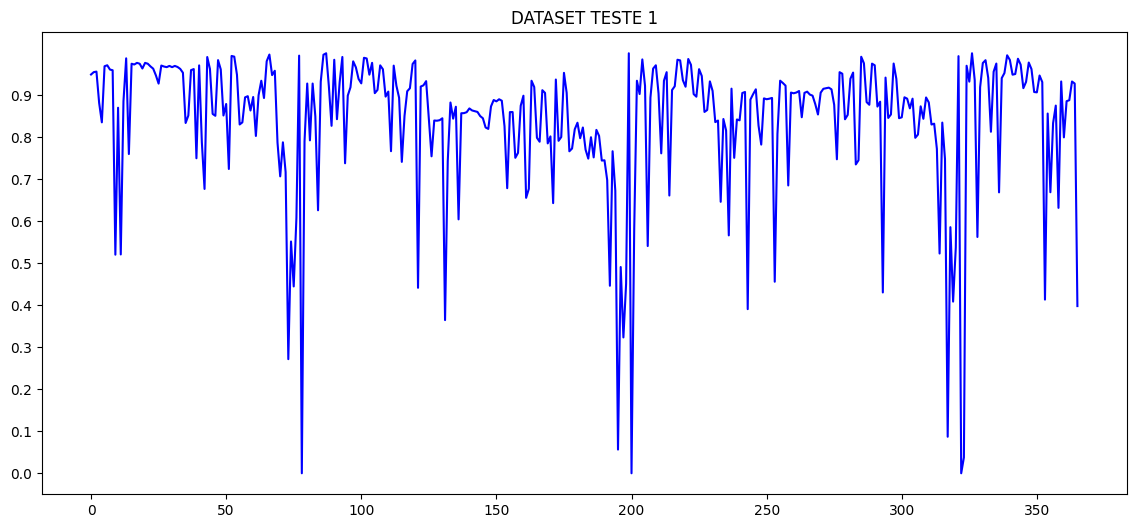

In [56]:
plt.figure(figsize=(14,6))
plt.plot(dataset_test_1, label="Original", color='blue')
plt.yticks(np.arange(0,1,step=0.1))
plt.title("DATASET TESTE 1")
plt.show()

In [57]:
timesteps = config['datasets'][dataset_type_du]["timesteps"]
output_steps = config['datasets'][dataset_type_du]["output_horizon"]
X_1, y_1 = create_dataset(dataset_test_1, timesteps, output_steps)
X_1 = X_1.reshape(X_1.shape[0], X_1.shape[1], 1)

#model1 = create_model(config, dataset_type_du, X_1, y_1,validation_method, 4)

X shape (336, 1)
y shape (336, 30)



Training with train-test split


c:\Users\renan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 1, 44)          │         8,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 44)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 44)          │        15,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 44)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 44)             │        15,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,774 (159.27 KB)

 Trainable params: 40,774 (159.27 KB)

 Non-trainable params: 0 (0.00 B)

X_test shape: (135, 1, 1)
y_test shape: (135, 30)
Epoch 1/100000
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.7688 - val_loss: 0.4531
Epoch 2/100000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2903 - val_loss: 0.1425
Epoch 3/100000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1735 - val_loss: 0.1267
Epoch 4/100000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1703 - val_loss: 0.1321
Epoch 5/100000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1608 - val_loss: 0.1255
Epoch 6/100000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1582 - val_loss: 0.1305
Epoch 7/100000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1559 - val_loss: 0.1503
Epoch 8/100000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1480 - val_loss: 0.1283
Epoch 9/100000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1480 - val_loss: 0.1188
Epoch 10/100000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1380 - val_loss: 0.1192
Epoch 11/100000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

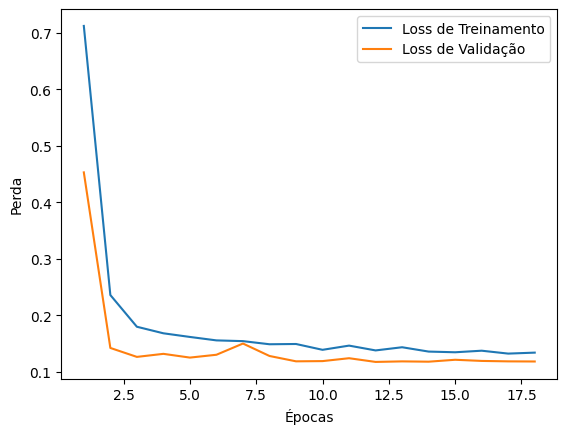

X shape (43, 1)
y shape (43, 30)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 1, 44)          │         8,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 44)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 1, 44)          │        15,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 44)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 44)             │        15,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,774 (159.27 KB)

 Trainable params: 40,774 (159.27 KB)

 Non-trainable params: 0 (0.00 B)

(1, 176)
(44, 176)
(176,)
(44, 176)
(44, 176)
(176,)
LSTM 1 treinable:  False
LSTM 2 treinable:  False
X_test shape: (35, 1, 1)
y_test shape: (35, 30)
Epoch 1/100000
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.8852 - val_loss: 0.8618
Epoch 2/100000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.8687 - val_loss: 0.8423
Epoch 3/100000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.8483 - val_loss: 0.8226
Epoch 4/100000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.8297 - val_loss: 0.8024
Epoch 5/100000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.8091 - val_loss: 0.7803
Epoch 6/100000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.7857 - val_loss: 0.7553
Epoch 7/100000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.7635 - val_loss: 0.7279
Epoch 8/100000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.7357 - val_loss: 0.6974
Epoch 9/100000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.7067 - val_loss: 0.6632
Epoch 10/100000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - los

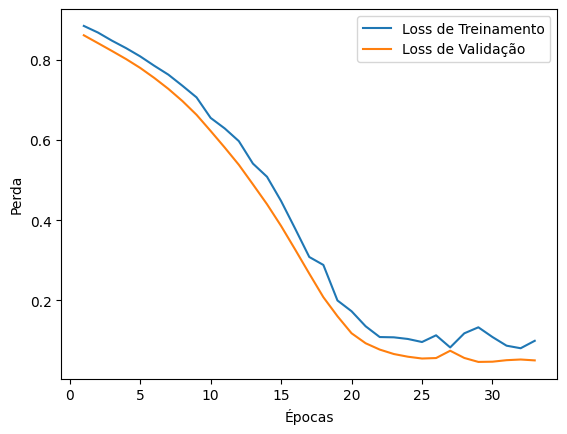

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


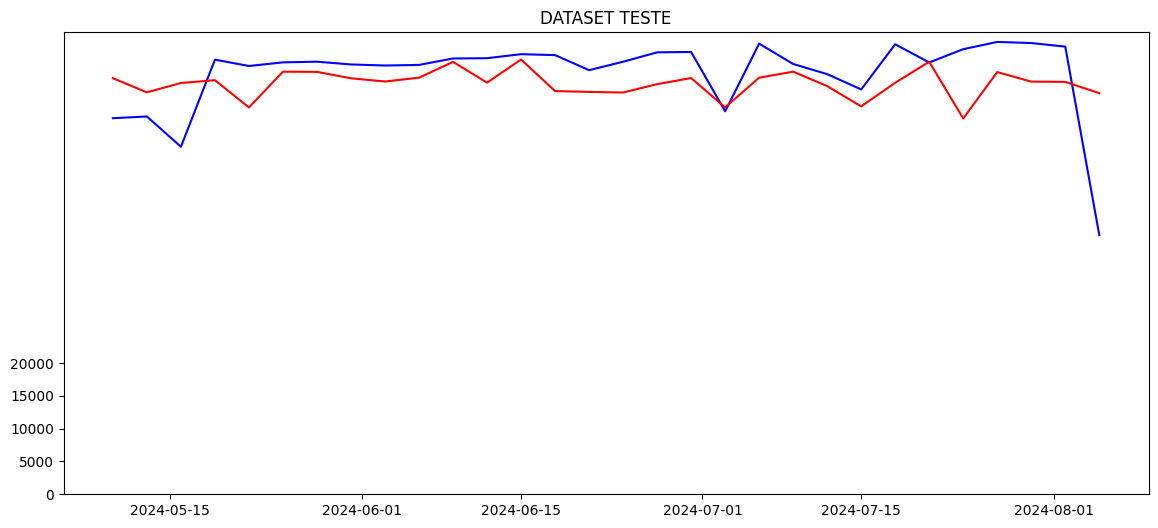

Output salvo em: Resultados_PSO/pso_du/3_days/avaliacao_testes/teste_1\avaliacao_with_method_split_0.8.txt


In [58]:
# Treinamento com k-fold cross-validation para k entre 2 e 9
# for k in range(2, 10):
#     validation_method = 'k-fold'
#     print(f"\nTraining with k-fold cross-validation, k={k}")
#     model1 = create_and_train_model(config, dataset_type_du, X_1, y_1, validation_method, k=k, tt_rate=0)
#     transfer_learning_model(config, model1, diretorio_pesos_teste_1, diretorio_avaliacao_teste_1, 'teste_1', validation_method, str(k))
    
# Treinamento com train-test split
# tt_rate = 0
# for k in range(1,10):
#     tt_rate += 0.10
#     print("\nTraining with train-test split")
#     validation_method = 'split'
#     model1 = create_and_train_model(config, dataset_type_du, X_1, y_1, validation_method, None, tt_rate)
#     transfer_learning_model(config, model1, diretorio_pesos_teste_1, diretorio_avaliacao_teste_1, 'teste_1', validation_method, tt_rate)
    
print("\nTraining with train-test split")
validation_method = 'split'
model1, X_test_, y_test_ = create_and_train_model(config, dataset_type_du, X_1, y_1, validation_method, None, 0.4)
X_test_1, y_test_1 = transfer_learning_model(config, model1, diretorio_pesos_teste_1, diretorio_avaliacao_teste_1, 'teste_1', validation_method, 0.8)



# # Treinamento com k-fold cross-validation para k entre 2 e 9
# for k in range(2, 10):
#     validation_method = 'k-fold'
#     print(f"\nTraining with k-fold cross-validation, k={k}")
#     model3 = train_model(X_3, y_3, validation_method, k, tt_rate=0)
#     transfer_learning_model(config, model3, diretorio_pesos_teste_3, diretorio_avaliacao_teste_3, 'teste_3', validation_method, str(k))
    
# # Treinamento com train-test split
# tt_rate = 0
# for k in range(1,10):
#     tt_rate += 0.10
#     print("\nTraining with train-test split")
#     validation_method = 'split'
#     model3 = train_model(X_3, y_3, validation_method, None, tt_rate)
#     transfer_learning_model(config, model3, diretorio_pesos_teste_3, diretorio_avaliacao_teste_3,'teste_3', validation_method, tt_rate)

## **LSTM CONCAT (TESTE 02)**

Prata I, II, III e Duas Unas.
Ações a serem testadas:
1. Padronizar cada dataset em separado (Prata I, II, III e Duas Unas);
2. Retirar do dataset Duas os dados de teste;
3. Concatenar os datasets;
4. Treinar o modelo com o novo dataset;
5. Validar o modelo com os dados de teste.

In [59]:
### DATASETS PARA TESTE 02 ###

indices = [1, 2, 3, 4]
dataset_test_2 = concatenate_selected_datasets(scaled_datasets, indices)

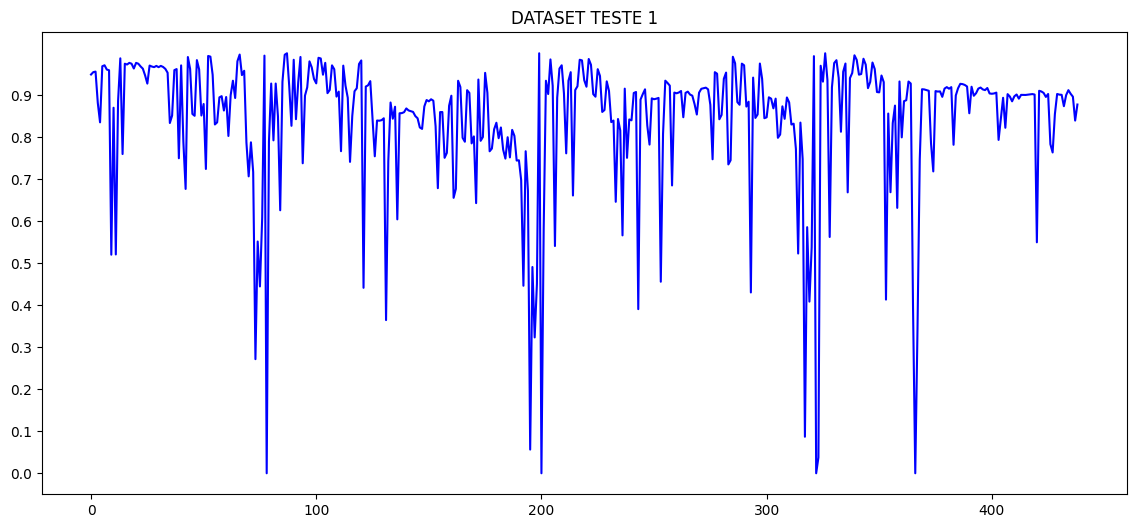

In [60]:
plt.figure(figsize=(14,6))
plt.plot(dataset_test_2, label="Original", color='blue')
plt.yticks(np.arange(0,1,step=0.1))
plt.title("DATASET TESTE 1")
plt.show()

In [61]:
timesteps = config['datasets'][dataset_type_du]["timesteps"]
output_steps = config['datasets'][dataset_type_du]["output_horizon"]
X, y = create_dataset(dataset_test_2, timesteps, output_steps)
X = X.reshape(X.shape[0], X.shape[1], 1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("X_train shape", np.array(X_train).shape)
# print("y_train shape", np.array(y_train).shape)
# print("X_test shape", np.array(X_test).shape)
# print("y_test shape", np.array(y_test).shape)

X shape (409, 1)
y shape (409, 30)


c:\Users\renan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 1, 44)          │         8,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 44)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 1, 44)          │        15,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 44)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 44)             │        15,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         1,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,774 (159.27 KB)

 Trainable params: 40,774 (159.27 KB)

 Non-trainable params: 0 (0.00 B)

X_test shape: (123, 1, 1)
y_test shape: (123, 30)
Epoch 1/100000
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.7204 - val_loss: 0.1455
Epoch 2/100000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1864 - val_loss: 0.1162
Epoch 3/100000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1693 - val_loss: 0.1324
Epoch 4/100000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1683 - val_loss: 0.1339
Epoch 5/100000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1566 - val_loss: 0.1278
Epoch 6/100000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1437 - val_loss: 0.1322
Epoch 7/100000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1481 - val_loss: 0.1549
Epoch 8/100000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1451 - val_loss: 0.1161
Epoch 9/100000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1390 - val_loss: 0.1158
Epoch 10/100000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1297 - val_loss: 0.1082
Epoch 11/100000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 

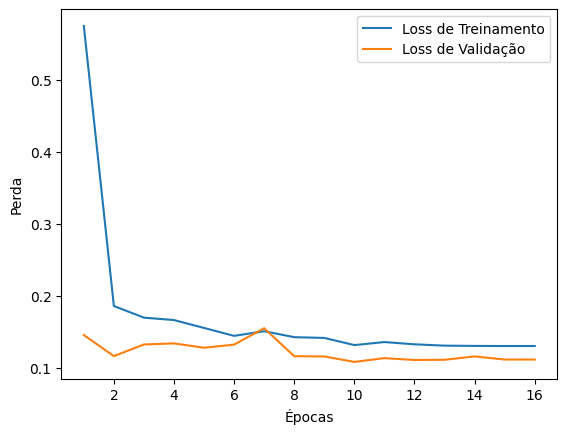

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


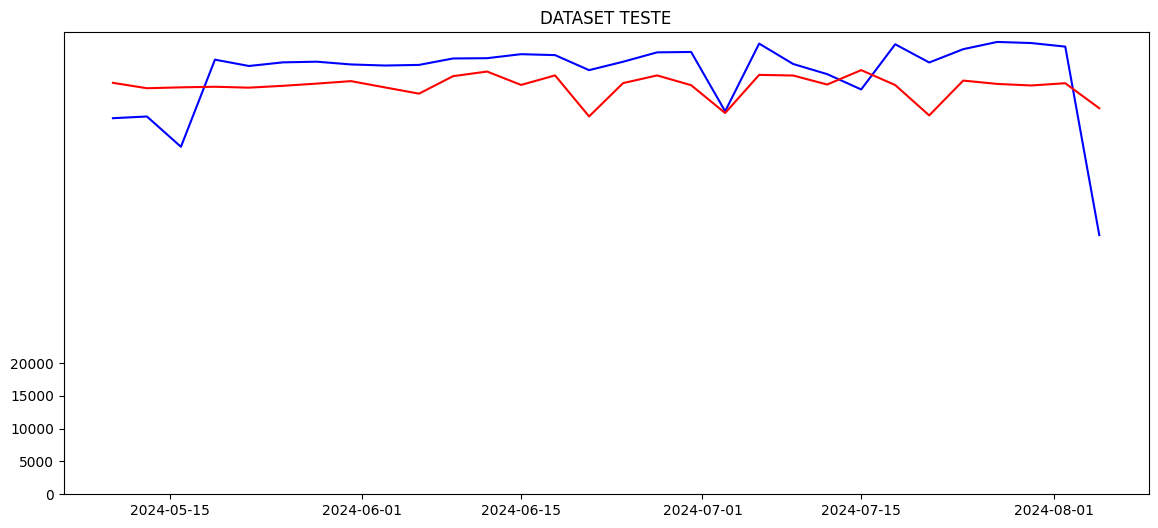

Output salvo em: Resultados_PSO/pso_du/3_days/avaliacao_testes/teste_2\avaliacao_with_method_split_0.3.txt


In [62]:
# for k in range(2,10):
#     model_2 = create_model(config, dataset_type_du, X, y, 'k-fold', k, 0)
#     results(model_2, duas_unas_validation_scaled, 'k-fold', diretorio_avaliacao_teste_2, k)

model_2, X_test_2, y_test_2 = create_and_train_model(config, dataset_type_du, X, y, 'split', 0, 0.3)
results(model_2, duas_unas_validation_scaled, 'split', diretorio_avaliacao_teste_2, 0.3)

## **LSTM MULTIVARIÁVEL**

In [63]:
timesteps = config['datasets'][dataset_type_du]["timesteps"]
output_steps = config['datasets'][dataset_type_du]["output_horizon"]

consumo_energia_train = scaled_datasets[4]
nivel_agua_train = scaled_datasets[5]

nivel_agua_train = nivel_agua_train.iloc[:,:1]

dataset_multivar = np.stack([consumo_energia_train, nivel_agua_train], axis=-1)

X, y = create_dataset_multivar(dataset_multivar, timesteps, output_steps)
X = X.reshape(X.shape[0], X.shape[1], 2)

X_train_multivar, X_val_multivar, yyy, yyyy = train_test_split(X, y, test_size=0.6, random_state=42)
print(f"X_train_multivar:",X_train_multivar.shape)
print(f"X_val_multivar:",X_val_multivar.shape)

X_0, y_0 = create_dataset(scaled_datasets[4], timesteps, output_steps)
X_0 = X_0.reshape(X_0.shape[0], X_0.shape[1], 1)

XXX, XXXX, y_train_multivar, y_val_multivar = train_test_split(X_0, y_0, test_size=0.6, random_state=42)
print(f"y_train_multivar:",y_train_multivar.shape)
print(f"y_val_multivar:",y_val_multivar.shape)

X_train_multivar: (17, 1, 2)
X_val_multivar: (26, 1, 2)
X shape (43, 1)
y shape (43, 30)
y_train_multivar: (17, 30)
y_val_multivar: (26, 30)


Epoch 1/10000


c:\Users\renan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - loss: 0.8746 - val_loss: 0.8472
Epoch 2/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.8417 - val_loss: 0.8187
Epoch 3/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8117 - val_loss: 0.7862
Epoch 4/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7775 - val_loss: 0.7442
Epoch 5/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7358 - val_loss: 0.6837
Epoch 6/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6690 - val_loss: 0.5830
Epoch 7/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5396 - val_loss: 0.4064
Epoch 8/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3555 - val_loss: 0.1738
Epoch 9/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1810 - val_loss: 0.1020
Epoch 10/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1715 - val_loss: 0.0827
Epoch 11/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1453 - val_loss: 0.0643
Epoch 12/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.13

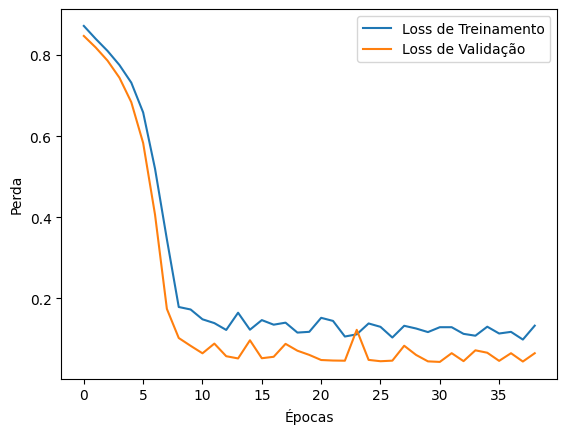

In [64]:
# Construir o modelo LSTM Multivar
model_lstm_multivar = Sequential()
model_lstm_multivar.add(LSTM(44, return_sequences=True, input_shape=(timesteps, 2)))
model_lstm_multivar.add(Dropout(0.39))
model_lstm_multivar.add(LSTM(44, return_sequences=True))
model_lstm_multivar.add(Dropout(0.39))
model_lstm_multivar.add(LSTM(44, return_sequences=False))
model_lstm_multivar.add(Dropout(0.39))

model_lstm_multivar.add(Dense(output_steps, activation = 'relu')) 

# Definir o otimizador com a taxa de aprendizado
optimizer = RMSprop(learning_rate=0.003)

# Compilar o modelo
model_lstm_multivar.compile(loss=wmae, optimizer=optimizer)

early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=8, restore_best_weights=True)

# Treinar o modelo
history = model_lstm_multivar.fit(X_train_multivar, y_train_multivar, epochs=10000, batch_size=5, validation_data=(X_val_multivar, y_val_multivar), callbacks=[early_stopping])

# Plotar as perdas de treinamento e validação
plt.plot(history.history['loss'], label='Loss de Treinamento')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

C:\Users\renan\AppData\Local\Temp\ipykernel_2916\3590595793.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  energia_teste = duas_unas_validation_scaled.iloc[0][0]
C:\Users\renan\AppData\Local\Temp\ipykernel_2916\3590595793.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  volume_teste = volume_du_df_validation.iloc[0][0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


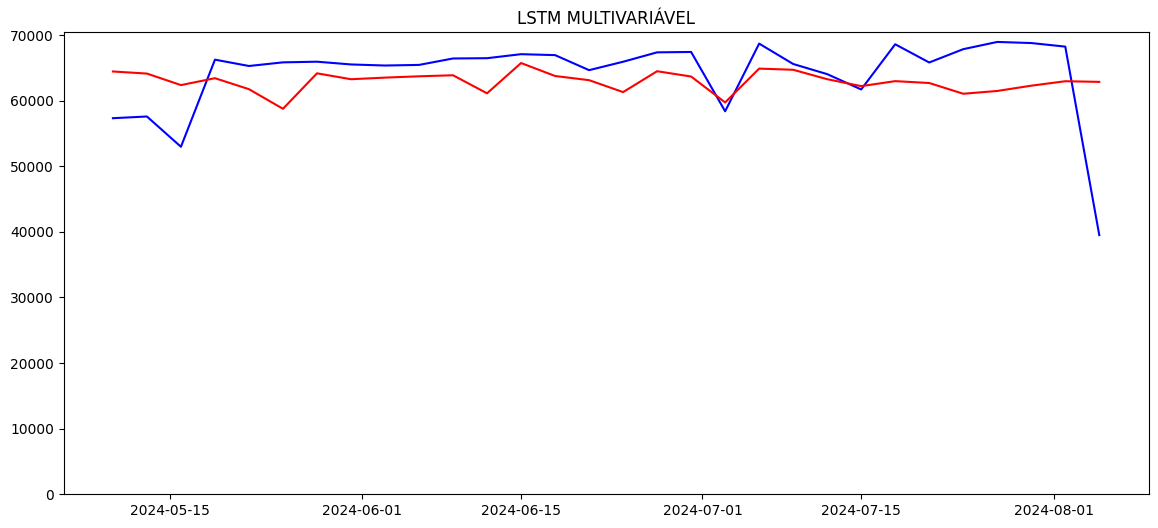

MAE(Erro absoluto médio) Score of LSTM model =  4493.018
 
MSE(Erro quadrático médio) Score of LSTM model =  37906260.299
 
RMSE(Raiz do erro quadrático médio) Score of LSTM model =  6156.806
 
MAPE(Erro percentual médio absoluto) Score of LSTM model =  0.07
 
2% Accuracy Score of LSTM model =  10.0
5% Accuracy Score of LSTM model =  50.0
10% Accuracy Score of LSTM model =  73.33
 
Erro %. acum 30 dias: 0.32 %
Erro %. acum 60 dias: 2.03 %
Erro %. acum 90 dias: 2.03 %
 
Erro %. acum 1º mês: 0.32 %
Erro %. acum 2º mês: 4.38 %
Erro %. acum 3º mês: 2.01 %
Terminada sequencia de testes


In [65]:
energia_teste = duas_unas_validation_scaled.iloc[0][0]
volume_teste = volume_du_df_validation.iloc[0][0]

dataset_multivar_teste = np.stack([energia_teste, volume_teste], axis=-1) # Preparar os 2 recursos de entrada para o formato correto

X = dataset_multivar_teste.reshape(1, 1, 2)

pred = model_lstm_multivar.predict(X)
y_pred_rescaled = scalers[4].inverse_transform(pred)
y_pred_rescaled = y_pred_rescaled.reshape(-1)  # Converter para 1D, se necessário
duas_unas_validation_rescaled = scalers[4].inverse_transform(duas_unas_validation_scaled[1:])

plt.figure(figsize=(14,6))
plt.plot(duas_unas_validation_scaled[1:].index, duas_unas_validation_rescaled, label="Original", color='blue')
plt.plot(duas_unas_validation_scaled[1:].index, y_pred_rescaled, label="Predict", color='red')
plt.yticks(np.arange(0,80000,step=10000))
plt.title("LSTM MULTIVARIÁVEL")

# Nome do arquivo incluindo a variável 'validation_method'
file_name = f'prediction_plot_with_LSTM_input_alt.png'

# Caminho completo para salvar o arquivo
save_path = os.path.join(diretorio_resultados_ensemble, file_name)

# Salvar o plot
plt.savefig(save_path)
plt.show()

avaliacao_multistep(y_pred_rescaled, duas_unas_validation_rescaled, diretorio_resultados_ensemble, 'LSTM_alt')

## **ENSEMBLE (LSTM TL + LSTM CONCAT)**

In [66]:
lstm_tl_pred = model1.predict(X_test_1)
print(lstm_tl_pred[0].shape)
lstm_concat_pred = []
for i in range(0,X_test_1.shape[0]):
    lstm_concat_pred.append(model_2.predict(X_test_1[i]))

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/stepWARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000026C1B176020> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
(30,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1

In [67]:
# Cria um novo dataset com as saídas dos modelos [30x1] e [30x1], 
# concatenando uma lista na outra para gerar a nova lista [60x1]
concat_preds_seq = []
for i in range(len(lstm_tl_pred)):    
    pred_lstm_tl_to_concat = lstm_tl_pred[i]
    pred_lstm_concat_to_concat = lstm_concat_pred[i][0]

    conc = np.concatenate(( pred_lstm_tl_to_concat,pred_lstm_concat_to_concat), axis=0)
    
    concat_preds_seq.append(conc)

concat_preds_seq = np.array(concat_preds_seq)
print(concat_preds_seq.shape)

(35, 60)


In [ ]:
# Cria um novo dataset com as saídas dos modelos [30x1] e [30x1], 
# alternando os elementos de cada lista para gerar a nova lista [60x1]
concat_preds_alt = []
for i in range(len(lstm_tl_pred)):    
    pred_lstm_tl_to_concat = lstm_tl_pred[i]
    pred_lstm_concat_to_concat = lstm_concat_pred[i][0]
    lista_combinada = [item for pair in zip(pred_lstm_tl_to_concat, pred_lstm_concat_to_concat) for item in pair]
    
    concat_preds_alt.append(lista_combinada)

concat_preds_alt = np.array(concat_preds_alt)
print(concat_preds_alt.shape)

(35, 60)


In [69]:
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(concat_preds_alt, y_test_1, test_size=0.7, random_state=42)

c:\Users\renan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - loss: 0.8548 - val_loss: 0.7463
Epoch 2/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.7200 - val_loss: 0.6838
Epoch 3/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.6619 - val_loss: 0.6375
Epoch 4/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.6188 - val_loss: 0.6182
Epoch 5/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.6025 - val_loss: 0.6043
Epoch 6/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.5850 - val_loss: 0.5881
Epoch 7/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.5686 - val_loss: 0.5687
Epoch 8/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.5498 - val_loss: 0.5600
Epoch 9/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.5423 - val_loss: 0.5471
Epoch 10/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.5289 - val_loss: 0.5347
Epoch 11/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.5172 - val_loss: 0.5242
Epoch 12/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/ste

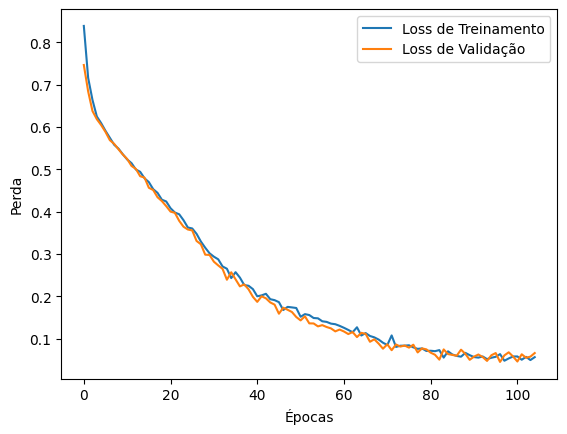

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# Definindo o tamanho da entrada e da saída
input_shape = 60  # Tamanho da sequência de entrada
output_shape = 30  # Tamanho da janela de previsão de saída

# Criando o modelo
model_mlp = Sequential()
model_mlp.add(Dense(256, input_dim=input_shape, activation='relu'))  # Camada de entrada
model_mlp.add(Dense(128, activation='relu'))                         # Camada oculta 1
model_mlp.add(Dense(64, activation='relu'))                          # Camada oculta 2
model_mlp.add(Dense(32, activation='relu'))                          # Camada oculta 3
model_mlp.add(Dense(output_shape, activation='linear'))              # Camada de saída

# Definindo o otimizador com a taxa de aprendizado
optimizer = RMSprop(learning_rate=0.0005)

# Compilando o modelo
model_mlp.compile(loss=wmae, optimizer=optimizer)

early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=8, restore_best_weights=True)

# Treinando o modelo
history = model_mlp.fit(X_train_mlp, y_train_mlp, epochs=10000, batch_size=4, validation_data=(X_test_mlp, y_test_mlp), callbacks=[early_stopping])

# Plotar as perdas de treinamento e validação
plt.plot(history.history['loss'], label='Loss de Treinamento')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [71]:
entrada_lstm = np.array([[[duas_unas_validation_scaled.iloc[0][0]]]])
pred_tl = model1.predict(entrada_lstm)
pred_concat = model_2.predict(entrada_lstm[0])
lista_combinada = [item for pair in zip(pred_tl, pred_concat) for item in pair]
concat_preds_alt = np.array(lista_combinada)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


C:\Users\renan\AppData\Local\Temp\ipykernel_2916\3695229093.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entrada_lstm = np.array([[[duas_unas_validation_scaled.iloc[0][0]]]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


MAE(Erro absoluto médio) Score of LSTM model =  5109.14
 
MSE(Erro quadrático médio) Score of LSTM model =  38258229.788
 
RMSE(Raiz do erro quadrático médio) Score of LSTM model =  6185.324
 
MAPE(Erro percentual médio absoluto) Score of LSTM model =  0.08
 
2% Accuracy Score of LSTM model =  6.67
5% Accuracy Score of LSTM model =  13.33
10% Accuracy Score of LSTM model =  73.33
 
Erro %. acum 30 dias: 1.94 %
Erro %. acum 60 dias: 4.45 %
Erro %. acum 90 dias: 4.04 %
 
Erro %. acum 1º mês: 1.94 %
Erro %. acum 2º mês: 6.96 %
Erro %. acum 3º mês: 3.23 %
Terminada sequencia de testes


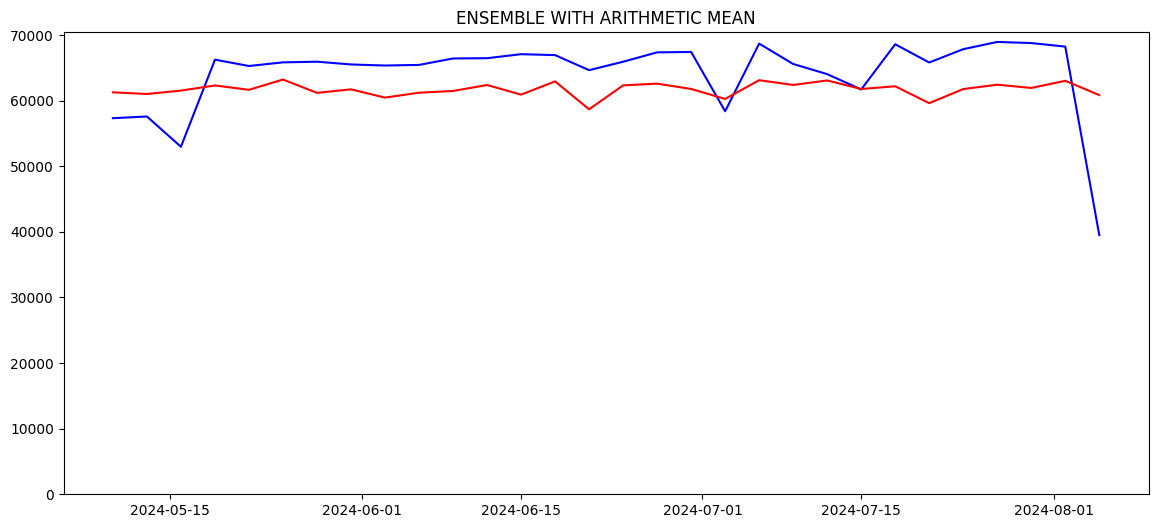

In [72]:
pred_med = []
for i in range (len(pred_tl[0])):
    med = (pred_tl[0][i] + pred_concat[0][i])/2
    #print(med)
    pred_med.append(med)

pred_med = np.array(pred_med)
pred_med_reshaped = pred_med.reshape(1, -1)

y_pred_rescaled = scalers[4].inverse_transform(pred_med_reshaped)
y_pred_rescaled = y_pred_rescaled.reshape(-1)  # Converte para 1D, se necessário
duas_unas_validation_rescaled = scalers[4].inverse_transform(duas_unas_validation_scaled[1:])

plt.figure(figsize=(14,6))
plt.plot(duas_unas_validation_scaled[1:].index, duas_unas_validation_rescaled, label="Original", color='blue')
plt.plot(duas_unas_validation_scaled[1:].index, y_pred_rescaled, label="Predict", color='red')
plt.yticks(np.arange(0,80000,step=10000))
plt.title("ENSEMBLE WITH ARITHMETIC MEAN")

avaliacao_multistep(y_pred_rescaled, duas_unas_validation_rescaled, diretorio_resultados_ensemble, 'MLP_seq')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


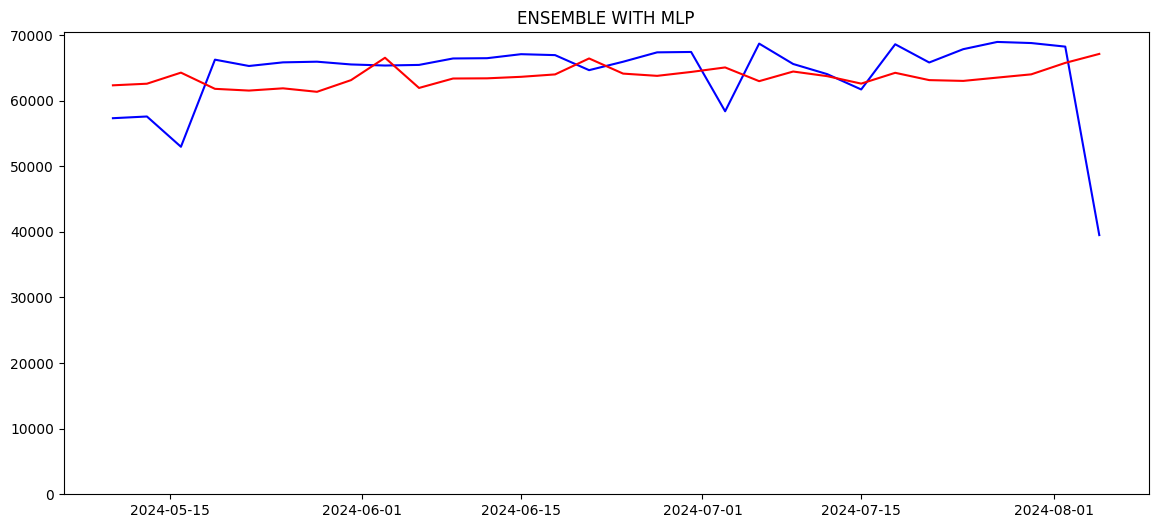

MAE(Erro absoluto médio) Score of LSTM model =  4493.867
 
MSE(Erro quadrático médio) Score of LSTM model =  42869865.285
 
RMSE(Raiz do erro quadrático médio) Score of LSTM model =  6547.508
 
MAPE(Erro percentual médio absoluto) Score of LSTM model =  0.07
 
2% Accuracy Score of LSTM model =  13.33
5% Accuracy Score of LSTM model =  43.33
10% Accuracy Score of LSTM model =  90.0
 
Erro %. acum 30 dias: 0.02 %
Erro %. acum 60 dias: 1.45 %
Erro %. acum 90 dias: 0.83 %
 
Erro %. acum 1º mês: 0.02 %
Erro %. acum 2º mês: 2.84 %
Erro %. acum 3º mês: 0.39 %
Terminada sequencia de testes


In [73]:
# X_val_concat = np.concatenate((pred_tl,pred_concat), axis=0)
# X_val_concat_array = np.array(X_val_concat)
X_val_concat = np.array(concat_preds_alt).reshape(1, -1)  # shape será (1, 60)

pred = model_mlp.predict(X_val_concat)
y_pred_rescaled = scalers[4].inverse_transform(pred)
y_pred_rescaled = y_pred_rescaled.reshape(-1)  # Converte para 1D, se necessário
duas_unas_validation_rescaled = scalers[4].inverse_transform(duas_unas_validation_scaled[1:])
y_pred_ensemble_MLP_2 = y_pred_rescaled

plt.figure(figsize=(14,6))
plt.plot(duas_unas_validation_scaled[1:].index, duas_unas_validation_rescaled, label="Original", color='blue')
plt.plot(duas_unas_validation_scaled[1:].index, y_pred_rescaled, label="Predict", color='red')
plt.yticks(np.arange(0,80000,step=10000))
plt.title("ENSEMBLE WITH MLP")

# Nome do arquivo incluindo a variável 'validation_method'
file_name = f'prediction_plot_with_MLP_input_seq.png'

# Caminho completo para salvar o arquivo
save_path = os.path.join(diretorio_resultados_ensemble, file_name)

# Salvar o plot
plt.savefig(save_path)
plt.show()

avaliacao_multistep(y_pred_rescaled, duas_unas_validation_rescaled, diretorio_resultados_ensemble, 'MLP_seq')

c:\Users\renan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 566ms/step - loss: 0.8002 - val_loss: 0.4603
Epoch 2/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.4945 - val_loss: 0.2783
Epoch 3/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - loss: 0.4478 - val_loss: 0.1699
Epoch 4/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.3117 - val_loss: 0.2440
Epoch 5/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - loss: 0.2878 - val_loss: 0.1472
Epoch 6/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.2489 - val_loss: 0.1855
Epoch 7/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 0.1628 - val_loss: 0.0964
Epoch 8/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - loss: 0.1834 - val_loss: 0.1628
Epoch 9/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - loss: 0.1466 - val_loss: 0.0681
Epoch 10/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - loss: 0.1402 - val_loss: 0.0661
Epoch 11/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - loss: 0.0886 - val_loss: 0.0781
Epoch 12/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1

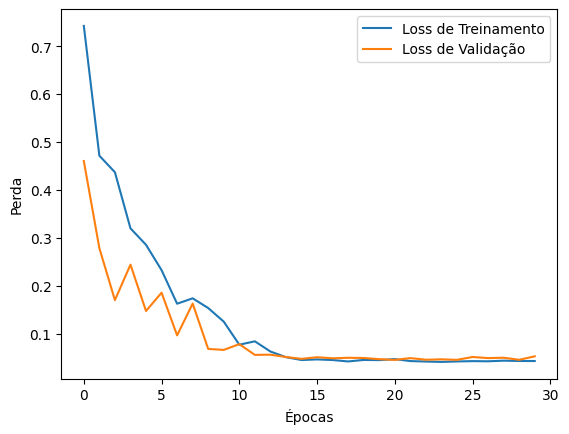

In [74]:
# Definindo o tamanho da entrada e da saída
input_shape = 60  # Tamanho da sequência de entrada
output_shape = 30  # Tamanho da janela de previsão de saída

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(44, return_sequences=True, input_shape=(input_shape, 1)))
model_lstm.add(Dropout(0.39))
model_lstm.add(LSTM(44, return_sequences=True))
model_lstm.add(Dropout(0.39))
model_lstm.add(LSTM(44, return_sequences=False))
model_lstm.add(Dropout(0.39))

model_lstm.add(Dense(output_steps, activation = 'relu')) 

# Definindo o otimizador com a taxa de aprendizado
optimizer = RMSprop(learning_rate=0.05)

# Compilando o modelo
model_lstm.compile(loss=wmae, optimizer=optimizer)

early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=9, restore_best_weights=True)

# Treinando o modelo
history = model_lstm.fit(X_train_mlp, y_train_mlp, epochs=10000, batch_size=2, validation_data=(X_test_mlp, y_test_mlp), callbacks=[early_stopping])

# Plotar as perdas de treinamento e validação
plt.plot(history.history['loss'], label='Loss de Treinamento')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


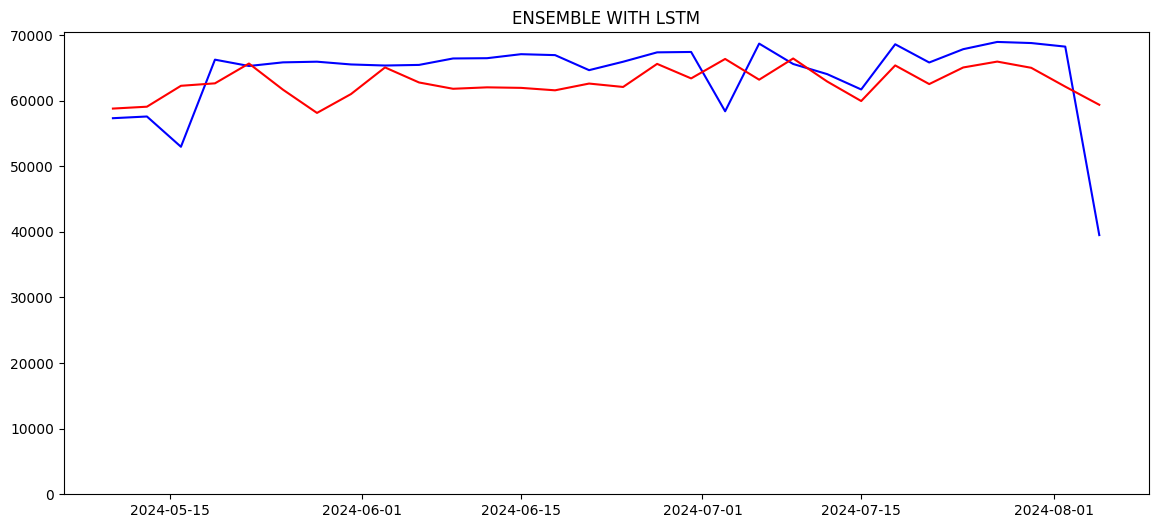

MAE(Erro absoluto médio) Score of LSTM model =  4205.827
 
MSE(Erro quadrático médio) Score of LSTM model =  30911334.562
 
RMSE(Raiz do erro quadrático médio) Score of LSTM model =  5559.796
 
MAPE(Erro percentual médio absoluto) Score of LSTM model =  0.07
 
2% Accuracy Score of LSTM model =  13.33
5% Accuracy Score of LSTM model =  43.33
10% Accuracy Score of LSTM model =  86.67
 
Erro %. acum 30 dias: 1.69 %
Erro %. acum 60 dias: 3.14 %
Erro %. acum 90 dias: 2.31 %
 
Erro %. acum 1º mês: 1.69 %
Erro %. acum 2º mês: 4.56 %
Erro %. acum 3º mês: 0.69 %
Terminada sequencia de testes


In [75]:
# X_val_concat = np.concatenate((pred_tl,pred_concat), axis=0)
# X_val_concat_array = np.array(X_val_concat)
X_val_concat = np.array(concat_preds_alt).reshape(1, -1)  # shape será (1, 60)

pred = model_lstm.predict(X_val_concat)
y_pred_rescaled = scalers[4].inverse_transform(pred)
y_pred_rescaled = y_pred_rescaled.reshape(-1)  # Converte para 1D, se necessário
duas_unas_validation_rescaled = scalers[4].inverse_transform(duas_unas_validation_scaled[1:])
y_pred_ensemble_LSTM_2 = y_pred_rescaled

plt.figure(figsize=(14,6))
plt.plot(duas_unas_validation_scaled[1:].index, duas_unas_validation_rescaled, label="Original", color='blue')
plt.plot(duas_unas_validation_scaled[1:].index, y_pred_rescaled, label="Predict", color='red')
plt.yticks(np.arange(0,80000,step=10000))
plt.title("ENSEMBLE WITH LSTM")

# Nome do arquivo incluindo a variável 'validation_method'
file_name = f'prediction_plot_with_LSTM_input_alt.png'

# Caminho completo para salvar o arquivo
save_path = os.path.join(diretorio_resultados_ensemble, file_name)

# Salvar o plot
plt.savefig(save_path)
plt.show()

avaliacao_multistep(y_pred_rescaled, duas_unas_validation_rescaled, diretorio_resultados_ensemble, 'LSTM_alt')

## **ENSEMBLE (LSTM TL + LSTM CONCAT + LSTM MULTIVAR)**

Como os dados de volume só estão disponíveis de 01-10-2023 a 09-07-2024, os dados de energia também precisarão obedecer ao mesmo intervalo. Como os modelos LSTM TL e LSTM Concat são univariáveis, devem utilizar X_test_1[0:12] (X_test_1[12] é o dado de energia na data limite 09-07-2024). Já LSTM Multivar deve utilizar X_val_multivar. Tantp X_test_1 quanto X_val_multivar serão utilizados nos respectivos modelos como entrada. As saídas serão concatenadas e servirão como dataset de treinamento para o MLP.

In [76]:
# Validação se os dados de entrada dos modelos singulares são iguais
for i in range(X_val_multivar.shape[0]):
    if X_val_multivar[i][0][0] == X_test_1[i][0][0]:
        print(True)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [77]:
lstm_tl_pred_2 = model1.predict(X_test_1[0:26])
lstm_concat_pred_2 = []
for i in range(0,X_val_multivar.shape[0]):
    lstm_concat_pred_2.append(model_2.predict(X_test_1[i]))
    
lstm_concat_pred_2 = np.array(lstm_concat_pred_2)
lstm_concat_pred_2 = lstm_concat_pred_2.reshape(26,30)

print(lstm_tl_pred_2.shape)
print(lstm_concat_pred_2.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [78]:
lstm_multivar_pred_2 = model_lstm_multivar.predict(X_val_multivar)
print(lstm_multivar_pred_2.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
(26, 30)


In [ ]:
# Cria um novo dataset com as saídas dos modelos [30x1], [30x1], [30x1], 
# alternando os elementos de cada lista para gerar a nova lista [90x1]
concat_preds_alt_2 = []
for i in range(0, len(lstm_concat_pred_2)):    
    pred_lstm_tl_to_concat_2 = lstm_tl_pred_2[i]
    pred_lstm_concat_to_concat_2 = lstm_concat_pred_2[i]
    pred_lstm_multivar_to_concat_2 = lstm_multivar_pred_2[i]
    lista_combinada = [item for pair in zip(pred_lstm_tl_to_concat, pred_lstm_concat_to_concat, pred_lstm_multivar_to_concat_2) for item in pair]
    concat_preds_alt_2.append(lista_combinada)

concat_preds_alt_2 = np.array(concat_preds_alt_2)
print(concat_preds_alt_2.shape)

y_ensemble2 = y_test_1[0:26]
X_train_ensemble2, X_test_ensemble2, y_train_ensemble2, y_test_ensemble2 = train_test_split(concat_preds_alt_2, y_ensemble2, test_size=0.3, random_state=42)

(26, 90)


MAE(Erro absoluto médio) Score of LSTM model =  5532.539
 
MSE(Erro quadrático médio) Score of LSTM model =  41959524.833
 
RMSE(Raiz do erro quadrático médio) Score of LSTM model =  6477.617
 
MAPE(Erro percentual médio absoluto) Score of LSTM model =  0.09
 
2% Accuracy Score of LSTM model =  6.67
5% Accuracy Score of LSTM model =  10.0
10% Accuracy Score of LSTM model =  76.67
 
Erro %. acum 30 dias: 2.77 %
Erro %. acum 60 dias: 5.27 %
Erro %. acum 90 dias: 4.99 %
 
Erro %. acum 1º mês: 2.77 %
Erro %. acum 2º mês: 7.77 %
Erro %. acum 3º mês: 4.42 %
Terminada sequencia de testes


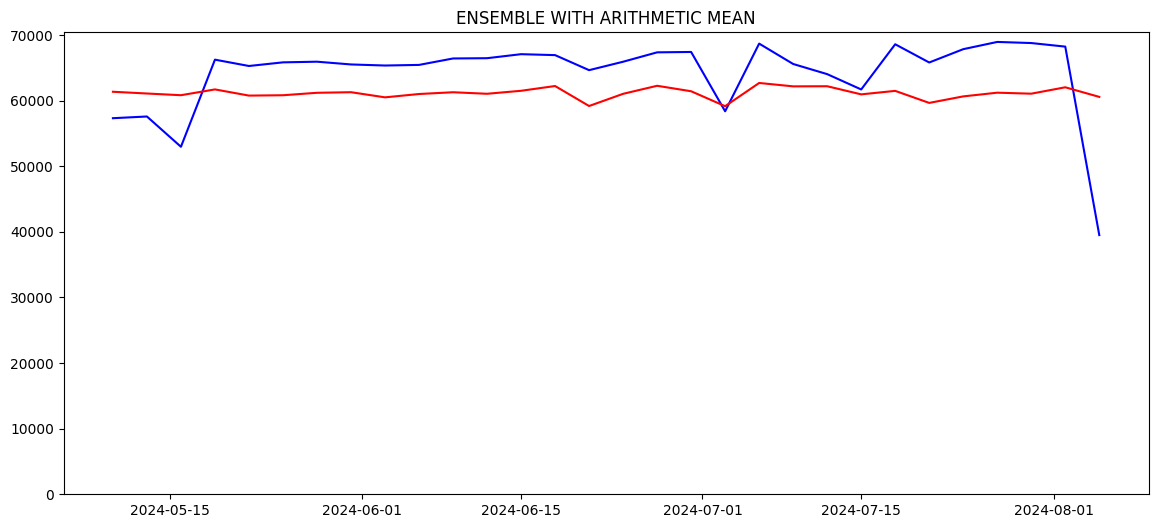

In [81]:
pred_med2 = []
for i in range (len(lstm_multivar_pred_2[0])):
    med = (lstm_tl_pred_2[0][i] + lstm_concat_pred_2[0][i] + lstm_multivar_pred_2[0][i])/3
    #print(med)
    pred_med2.append(med)

pred_med2 = np.array(pred_med2)
pred_med2_reshaped = pred_med2.reshape(1, -1)

y_pred2_rescaled = scalers[4].inverse_transform(pred_med2_reshaped)
y_pred2_rescaled = y_pred2_rescaled.reshape(-1)  # Converte para 1D, se necessário
duas_unas_validation_rescaled = scalers[4].inverse_transform(duas_unas_validation_scaled[1:])

plt.figure(figsize=(14,6))
plt.plot(duas_unas_validation_scaled[1:].index, duas_unas_validation_rescaled, label="Original", color='blue')
plt.plot(duas_unas_validation_scaled[1:].index, y_pred2_rescaled, label="Predict", color='red')
plt.yticks(np.arange(0,80000,step=10000))
plt.title("ENSEMBLE WITH ARITHMETIC MEAN")

avaliacao_multistep(y_pred2_rescaled, duas_unas_validation_rescaled, diretorio_resultados_ensemble, 'MLP_seq')

Epoch 1/10000


c:\Users\renan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6733 - val_loss: 0.4377
Epoch 2/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4357 - val_loss: 0.3290
Epoch 3/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3283 - val_loss: 0.3270
Epoch 4/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2858 - val_loss: 0.2535
Epoch 5/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2252 - val_loss: 0.1775
Epoch 6/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1881 - val_loss: 0.1863
Epoch 7/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1671 - val_loss: 0.1336
Epoch 8/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1412 - val_loss: 0.0990
Epoch 9/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1158 - val_loss: 0.0872
Epoch 10/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0982 - val_loss: 0.0922
Epoch 11/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0945 - val_loss: 0.0944
Epoch 12/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.081

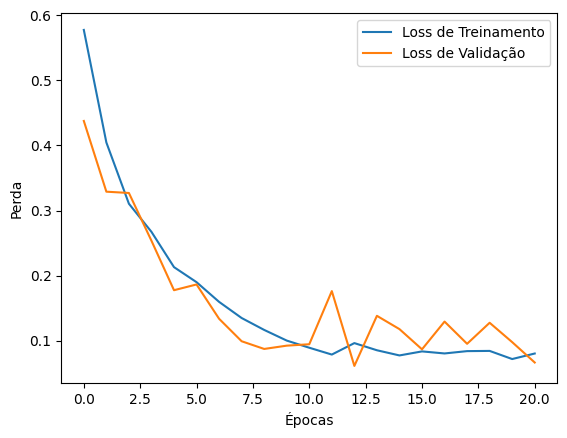

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# Definindo o tamanho da entrada e da saída
input_shape = 90  # Tamanho da sequência de entrada
output_shape = 30  # Tamanho da janela de previsão de saída

# Criando o modelo
model_mlp2 = Sequential()
model_mlp2.add(Dense(256, input_dim=input_shape, activation='relu'))
model_mlp2.add(Dense(128, activation='relu'))                         # Camada oculta 1
model_mlp2.add(Dense(64, activation='relu'))                          # Camada oculta 2
model_mlp2.add(Dense(32, activation='relu'))                          # Camada oculta 3
model_mlp2.add(Dense(output_shape, activation='linear'))              # Camada de saída

# Definindo o otimizador com a taxa de aprendizado
optimizer = RMSprop(learning_rate=0.001)

# Compilando o modelo
model_mlp2.compile(loss=wmae, optimizer=optimizer)

early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=8, restore_best_weights=True)

# Treinando o modelo
history = model_mlp2.fit(X_train_ensemble2, y_train_ensemble2, epochs=10000, batch_size=2, validation_data=(X_test_ensemble2, y_test_ensemble2), callbacks=[early_stopping])

# Plotar as perdas de treinamento e validação
plt.plot(history.history['loss'], label='Loss de Treinamento')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [83]:
# Obtenção da entrada de validação do modelo ensemble - cada modelo singular recebe a entrada de validação e 
# as saídas 1x30 de cada modelo são concatenadas para servir de entrada para o modelo ensemble
entrada_lstm = np.array([[[duas_unas_validation_scaled.iloc[0][0]]]])
entrada_multivar =  np.concatenate((entrada_lstm, np.array([[[0.4784172]]])), axis=2)
pred_tl2 = model1.predict(entrada_lstm)
pred_concat2 = model_2.predict(entrada_lstm[0])
pred_multivar2 = model_lstm_multivar.predict(entrada_multivar)
lista_combinada2 = [item for pair in zip(pred_tl2, pred_concat2, pred_multivar2) for item in pair]
concat_preds_alt2 = np.array(lista_combinada2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


C:\Users\renan\AppData\Local\Temp\ipykernel_2916\2791223523.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entrada_lstm = np.array([[[duas_unas_validation_scaled.iloc[0][0]]]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


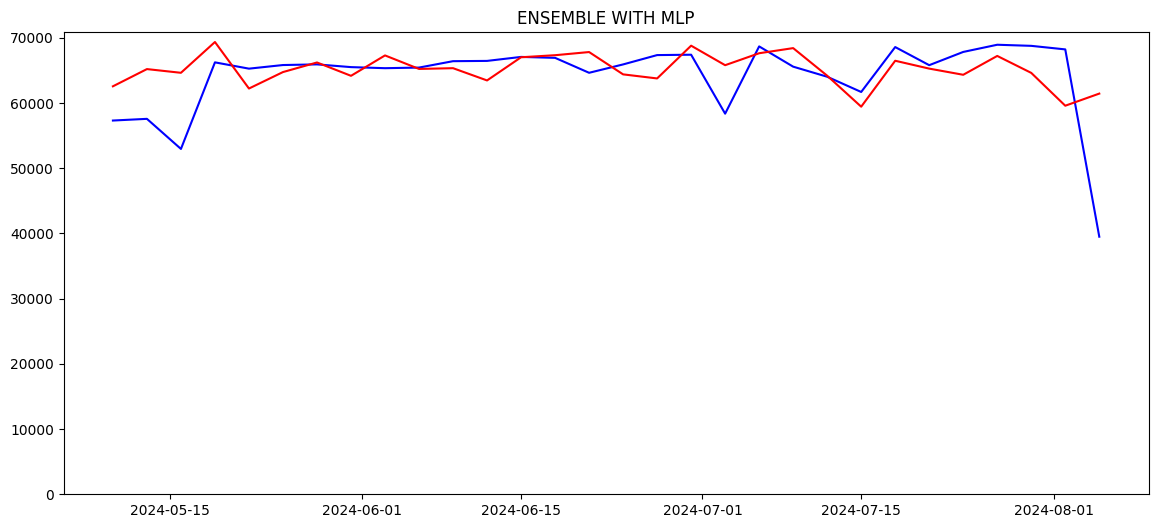

MAE(Erro absoluto médio) Score of LSTM model =  3537.597
 
MSE(Erro quadrático médio) Score of LSTM model =  31624672.788
 
RMSE(Raiz do erro quadrático médio) Score of LSTM model =  5623.582
 
MAPE(Erro percentual médio absoluto) Score of LSTM model =  0.06
 
2% Accuracy Score of LSTM model =  30.0
5% Accuracy Score of LSTM model =  70.0
10% Accuracy Score of LSTM model =  83.33
 
Erro %. acum 30 dias: 3.72 %
Erro %. acum 60 dias: 2.01 %
Erro %. acum 90 dias: 1.46 %
 
Erro %. acum 1º mês: 3.72 %
Erro %. acum 2º mês: 0.32 %
Erro %. acum 3º mês: 0.32 %
Terminada sequencia de testes


In [84]:
X_val_concat2 = np.array(concat_preds_alt2).reshape(1, -1)  # shape será (1, 90)

pred2 = model_mlp2.predict(X_val_concat2)
y_pred_rescaled = scalers[4].inverse_transform(pred2)
y_pred_rescaled = y_pred_rescaled.reshape(-1)  # Converte para 1D, se necessário
duas_unas_validation_rescaled = scalers[4].inverse_transform(duas_unas_validation_scaled[1:])
y_pred_ensemble_MLP_3 = y_pred_rescaled

plt.figure(figsize=(14,6))
plt.plot(duas_unas_validation_scaled[1:].index, duas_unas_validation_rescaled, label="Original", color='blue')
plt.plot(duas_unas_validation_scaled[1:].index, y_pred_rescaled, label="Predict", color='red')
plt.yticks(np.arange(0,80000,step=10000))
plt.title("ENSEMBLE WITH MLP")

# Nome do arquivo incluindo a variável 'validation_method'
file_name = f'prediction_plot_with_MLP_input_seq.png'

# Caminho completo para salvar o arquivo
save_path = os.path.join(diretorio_resultados_ensemble, file_name)

# Salvar o plot
plt.savefig(save_path)
plt.show()

avaliacao_multistep(y_pred_rescaled, duas_unas_validation_rescaled, diretorio_resultados_ensemble, 'MLP_seq')

Epoch 1/10000


c:\Users\renan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.8141 - val_loss: 0.6433
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.5710 - val_loss: 0.4621
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4816 - val_loss: 0.3746
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.4462 - val_loss: 0.3503
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.4770 - val_loss: 0.3410
Epoch 6/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4373 - val_loss: 0.3098
Epoch 7/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.4000 - val_loss: 0.2948
Epoch 8/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3878 - val_loss: 0.2823
Epoch 9/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3601 - val_loss: 0.2547
Epoch 10/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3675 - val_loss: 0.2467
Epoch 11/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3244 - val_loss: 0.1951
Epoch 12/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.33

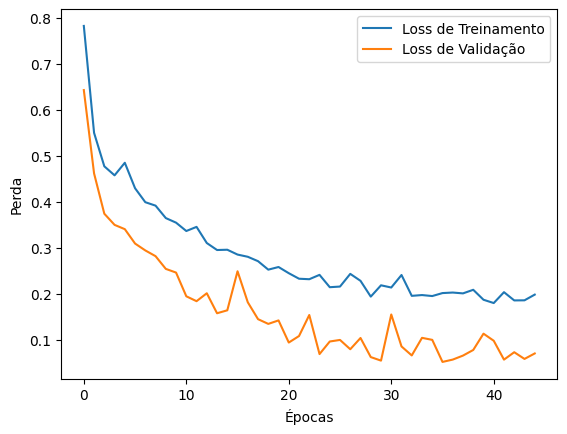

In [ ]:
# Definindo o tamanho da entrada e da saída
input_shape = 90  # Tamanho da sequência de entrada
output_shape = 30  # Tamanho da janela de previsão de saída

# Build the LSTM model
model_lstm2 = Sequential()
model_lstm2.add(LSTM(44, return_sequences=True, input_shape=(input_shape, 1)))
model_lstm2.add(Dropout(0.39))
model_lstm2.add(LSTM(44, return_sequences=False))
model_lstm2.add(Dropout(0.39))

model_lstm2.add(Dense(output_steps, activation = 'relu')) 

# Definindo o otimizador com a taxa de aprendizado
optimizer = RMSprop(learning_rate=0.0008)

# Compilando o modelo
model_lstm2.compile(loss=wmae, optimizer=optimizer)

early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=9, restore_best_weights=True)

# Treinando o modelo
history = model_lstm2.fit(X_train_ensemble2, y_train_ensemble2, epochs=10000, batch_size=3, validation_data=(X_test_ensemble2, y_test_ensemble2), callbacks=[early_stopping])

# Plotar as perdas de treinamento e validação
plt.plot(history.history['loss'], label='Loss de Treinamento')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


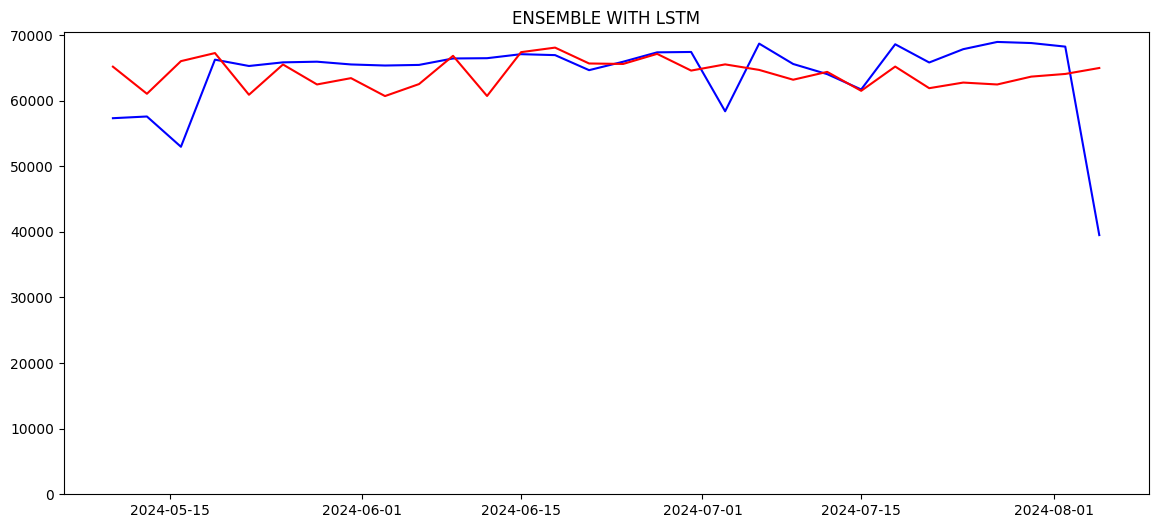

MAE(Erro absoluto médio) Score of LSTM model =  4100.456
 
MSE(Erro quadrático médio) Score of LSTM model =  40511112.485
 
RMSE(Raiz do erro quadrático médio) Score of LSTM model =  6364.834
 
MAPE(Erro percentual médio absoluto) Score of LSTM model =  0.06
 
2% Accuracy Score of LSTM model =  33.33
5% Accuracy Score of LSTM model =  46.67
10% Accuracy Score of LSTM model =  83.33
 
Erro %. acum 30 dias: 1.19 %
Erro %. acum 60 dias: 0.34 %
Erro %. acum 90 dias: 0.03 %
 
Erro %. acum 1º mês: 1.19 %
Erro %. acum 2º mês: 0.48 %
Erro %. acum 3º mês: 0.78 %
Terminada sequencia de testes


In [86]:
X_val_concat2 = np.array(concat_preds_alt_2).reshape(1, -1)  # shape será (1, 60)

pred2 = model_lstm2.predict(X_val_concat2)
y_pred_rescaled2 = scalers[4].inverse_transform(pred2)
y_pred_rescaled22 = y_pred_rescaled2.reshape(-1)  # Converte para 1D, se necessário
duas_unas_validation_rescaled = scalers[4].inverse_transform(duas_unas_validation_scaled[1:])
y_pred_ensemble_LSTM_3 = y_pred_rescaled22

plt.figure(figsize=(14,6))
plt.plot(duas_unas_validation_scaled[1:].index, duas_unas_validation_rescaled, label="Original", color='blue')
plt.plot(duas_unas_validation_scaled[1:].index, y_pred_rescaled22, label="Predict", color='red')
plt.yticks(np.arange(0,80000,step=10000))
plt.title("ENSEMBLE WITH LSTM")

# Nome do arquivo incluindo a variável 'validation_method'
file_name = f'prediction_plot_with_LSTM_input_alt.png'

# Caminho completo para salvar o arquivo
save_path = os.path.join(diretorio_resultados_ensemble, file_name)

# Salvar o plot
plt.savefig(save_path)
plt.show()

avaliacao_multistep(y_pred_rescaled22, duas_unas_validation_rescaled, diretorio_resultados_ensemble, 'LSTM_alt')

## **TESTES PARA ESCOLHA DO MELHOR MODELO**

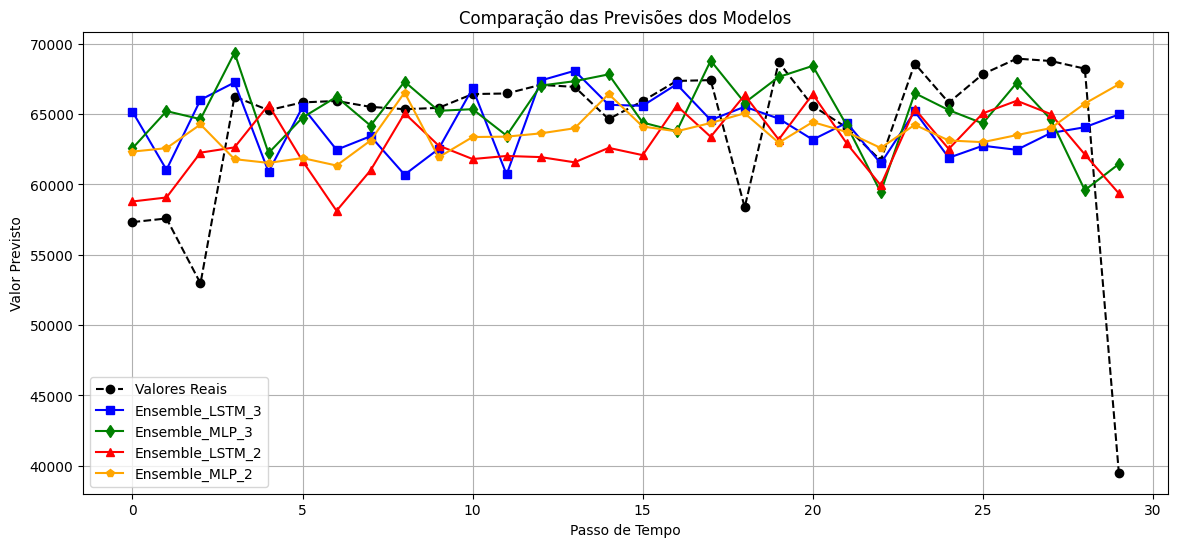

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Criando o gráfico
plt.figure(figsize=(14, 6))
plt.plot(duas_unas_validation_rescaled, label='Valores Reais', marker='o', linestyle='dashed', color='black')
plt.plot(y_pred_ensemble_LSTM_3, label='Ensemble_LSTM_3', marker='s', linestyle='solid', color='blue')
plt.plot(y_pred_ensemble_MLP_3, label='Ensemble_MLP_3', marker='d', linestyle='solid', color='green')
plt.plot(y_pred_ensemble_LSTM_2, label='Ensemble_LSTM_2', marker='^', linestyle='solid', color='red')
plt.plot(y_pred_ensemble_MLP_2, label='Ensemble_MLP_2', marker='p', linestyle='solid', color='orange')

plt.xlabel("Passo de Tempo")
plt.ylabel("Valor Previsto")
plt.legend()
plt.title("Comparação das Previsões dos Modelos")
plt.grid()
plt.show()

In [88]:
from scipy.stats import ks_2samp
import numpy as np

# Teste de Kolmogorov-Smirnov
# Compara as distribuições de y_true e y_pred para verificar se são estatisticamente semelhantes.
# Hipótese Nula (H0): As distribuições são idênticas.

y_true = np.array(duas_unas_validation_rescaled).reshape(-1)
list_predictions = [y_pred_ensemble_LSTM_3, y_pred_ensemble_MLP_3, y_pred_ensemble_LSTM_2, y_pred_ensemble_MLP_2]

for i in range(len(list_predictions)):
    ks_statistic, ks_p_value = ks_2samp(y_true, list_predictions[i])

    print(f"Teste KS - Estatística: {ks_statistic:.4f}, Valor-p: {ks_p_value:.4f}")

    if ks_p_value < 0.05:
        print("Rejeitamos H0: As distribuições são diferentes.")
    else:
        print("Não rejeitamos H0: As distribuições são semelhantes.")

Teste KS - Estatística: 0.4000, Valor-p: 0.0156
Rejeitamos H0: As distribuições são diferentes.
Teste KS - Estatística: 0.2667, Valor-p: 0.2391
Não rejeitamos H0: As distribuições são semelhantes.
Teste KS - Estatística: 0.5333, Valor-p: 0.0003
Rejeitamos H0: As distribuições são diferentes.
Teste KS - Estatística: 0.6000, Valor-p: 0.0000
Rejeitamos H0: As distribuições são diferentes.


In [89]:
from scipy.stats import friedmanchisquare
import numpy as np

# Teste de Friedman
# Para comparar quatro modelos ensemble (LSTM_2, MLP_2, LSTM_3, MLP_3), podemos usar o teste de Friedman,
# pois os modelos fazem previsões sobre os mesmos 30 passos futuros.
# Se p < 0.05, pelo menos um modelo tem desempenho significativamente diferente.

stat, p_value = friedmanchisquare(y_pred_ensemble_LSTM_3, y_pred_ensemble_LSTM_2, y_pred_ensemble_MLP_2)

print(f"Estatística de Friedman: {stat}, p-valor: {p_value}")

if p_value < 0.05:
    print("Rejeitamos H0: Pelo menos um dos modelos tem uma distribuição de erros significativamente diferente dos outros.")
else:
    print("Não rejeitamos H0: As distribuições dos erros dos modelos são estatisticamente idênticas.")


Estatística de Friedman: 3.46666666666664, p-valor: 0.1766944457565991
Não rejeitamos H0: As distribuições dos erros dos modelos são estatisticamente idênticas.


In [90]:
from scipy.stats import wilcoxon
# Teste de Wilcoxon Signed-Rank
# Testa se a mediana da diferença entre y_true e y_pred é significativamente diferente de zero.

for i in range(len(list_predictions)):
    wilcoxon_statistic, wilcoxon_p_value = wilcoxon(list_predictions[i],y_true)
    
    # Extraindo os valores corretamente
    wilcoxon_statistic = wilcoxon_statistic.item()
    wilcoxon_p_value = wilcoxon_p_value.item()

    print(f"Teste Wilcoxon para o modelo - Estatística: {wilcoxon_statistic:.4f}, Valor-p: {wilcoxon_p_value:.4f}")

    if wilcoxon_p_value < 0.05:
        print("Rejeitamos H0: A mediana das diferenças não é zero.")
    else:
        print("Não rejeitamos H0: A mediana das diferenças é zero.")


Teste Wilcoxon para o modelo - Estatística: 173.0000, Valor-p: 0.2286
Não rejeitamos H0: A mediana das diferenças é zero.
Teste Wilcoxon para o modelo - Estatística: 231.0000, Valor-p: 0.9838
Não rejeitamos H0: A mediana das diferenças é zero.
Teste Wilcoxon para o modelo - Estatística: 103.0000, Valor-p: 0.0066
Rejeitamos H0: A mediana das diferenças não é zero.
Teste Wilcoxon para o modelo - Estatística: 147.0000, Valor-p: 0.0803
Não rejeitamos H0: A mediana das diferenças é zero.


In [91]:
# Teste de Wilcoxon Signed-Rank entre os Modelos "Aprovados" na Etapa Anterior do Teste de Wilcoxon

# Cálculo do índice de Theil
list_predictions_2 = [y_pred_ensemble_LSTM_3, y_pred_ensemble_MLP_3, y_pred_ensemble_MLP_2]

### TESTE ENTRE ENSEMBLE-LSTM-3 E ENSEMBLE-MLP-3 ###

wilcoxon_statistic, wilcoxon_p_value = wilcoxon(list_predictions_2[0],list_predictions_2[1])
    
# Extraindo os valores corretamente
wilcoxon_statistic = wilcoxon_statistic.item()
wilcoxon_p_value = wilcoxon_p_value.item()

print(f"Teste Wilcoxon para o modelo - Estatística: {wilcoxon_statistic:.4f}, Valor-p: {wilcoxon_p_value:.4f}")

if wilcoxon_p_value < 0.05:
    print("Rejeitamos H0: A mediana das diferenças não é zero.")
else:
    print("Não rejeitamos H0: A mediana das diferenças é zero.")
    
### TESTE ENTRE ENSEMBLE-LSTM-3 E ENSEMBLE-MLP-2 ###
    
wilcoxon_statistic, wilcoxon_p_value = wilcoxon(list_predictions_2[0],list_predictions_2[2])
    
# Extraindo os valores corretamente
wilcoxon_statistic = wilcoxon_statistic.item()
wilcoxon_p_value = wilcoxon_p_value.item()

print(f"Teste Wilcoxon para o modelo - Estatística: {wilcoxon_statistic:.4f}, Valor-p: {wilcoxon_p_value:.4f}")

if wilcoxon_p_value < 0.05:
    print("Rejeitamos H0: A mediana das diferenças não é zero.")
else:
    print("Não rejeitamos H0: A mediana das diferenças é zero.")

### TESTE ENTRE ENSEMBLE-MLP-2 E ENSEMBLE-MLP-3 ###

wilcoxon_statistic, wilcoxon_p_value = wilcoxon(list_predictions_2[2],list_predictions_2[1])
    
# Extraindo os valores corretamente
wilcoxon_statistic = wilcoxon_statistic.item()
wilcoxon_p_value = wilcoxon_p_value.item()

print(f"Teste Wilcoxon para o modelo - Estatística: {wilcoxon_statistic:.4f}, Valor-p: {wilcoxon_p_value:.4f}")

if wilcoxon_p_value < 0.05:
    print("Rejeitamos H0: A mediana das diferenças não é zero.")
else:
    print("Não rejeitamos H0: A mediana das diferenças é zero.")


Teste Wilcoxon para o modelo - Estatística: 146.0000, Valor-p: 0.0767
Não rejeitamos H0: A mediana das diferenças é zero.
Teste Wilcoxon para o modelo - Estatística: 182.0000, Valor-p: 0.3085
Não rejeitamos H0: A mediana das diferenças é zero.
Teste Wilcoxon para o modelo - Estatística: 76.0000, Valor-p: 0.0008
Rejeitamos H0: A mediana das diferenças não é zero.


In [92]:
import numpy as np

# Cálculo do índice de Theil

for i in range(len(list_predictions_2)):
    numerador = np.sqrt(np.mean((y_true - list_predictions_2[i]) ** 2))
    denominador = np.sqrt(np.mean(y_true ** 2))

    theil_u = numerador / denominador

    print(f"Índice de Theil (U): {theil_u:.4f}")

Índice de Theil (U): 0.0987
Índice de Theil (U): 0.0872
Índice de Theil (U): 0.1016


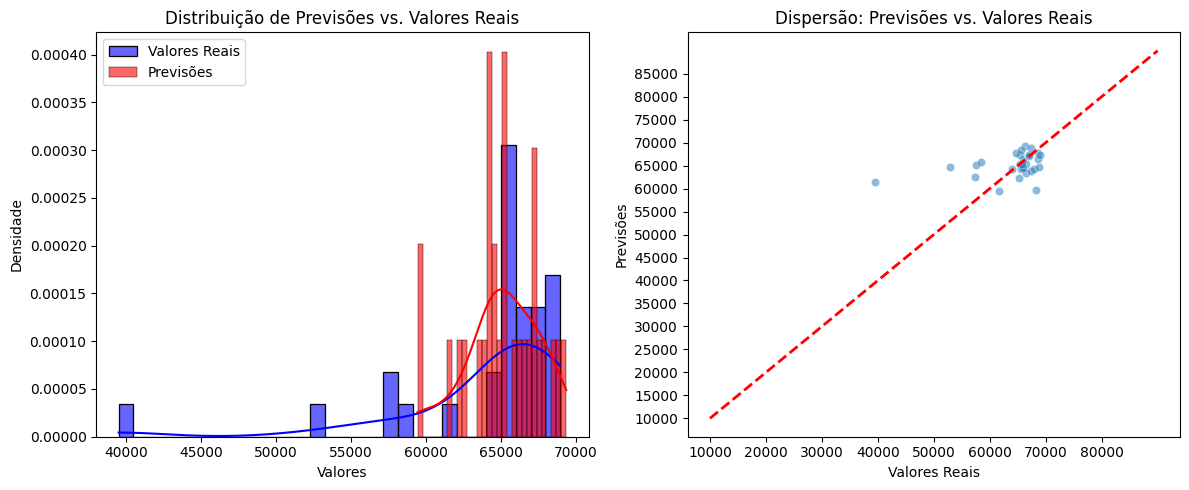

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(y_true, y_pred, title="Distribuição de Previsões vs Valores Reais"):
    """
    Plota a distribuição de y_true e y_pred em histogramas sobrepostos e um gráfico de dispersão.
    
    Parâmetros:
    - y_true: array ou lista com os valores reais.
    - y_pred: array ou lista com as previsões.
    - title: título do gráfico (opcional).
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    plt.figure(figsize=(12, 5))

    # 1. Histograma com KDE para comparar distribuições
    plt.subplot(1, 2, 1)
    sns.histplot(y_true, label="Valores Reais", color="blue", kde=True, stat="density", bins=30, alpha=0.6)
    sns.histplot(y_pred, label="Previsões", color="red", kde=True, stat="density", bins=30, alpha=0.6)
    plt.xlabel("Valores")
    plt.ylabel("Densidade")
    plt.title("Distribuição de Previsões vs. Valores Reais")
    plt.legend()

    # 2. Gráfico de dispersão para avaliar a relação entre previsões e valores reais
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot((10000,90000), (10000, 90000), color="red", linestyle="--", linewidth=2)  # Linha de referência y=x
    plt.yticks(np.arange(10000,90000,step=5000))
    plt.xticks(np.arange(10000,90000,step=10000))
    plt.xlabel("Valores Reais")
    plt.ylabel("Previsões")
    plt.title("Dispersão: Previsões vs. Valores Reais")

    plt.tight_layout()
    plt.show()

plot_distribution(y_true, y_pred_ensemble_MLP_3)


## **RESULTADOS COM DADOS EMULADOS**

Text(0.5, 1.0, 'DADOS EMULADOS APÓS ESCALONAMENTO')

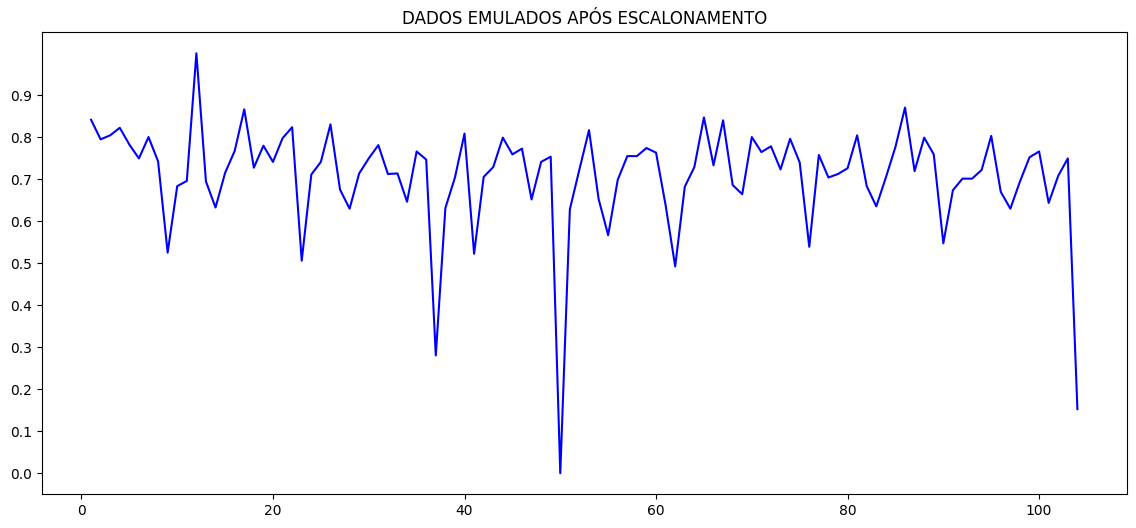

In [94]:
timesteps = config['datasets'][dataset_type_du]["timesteps"]
output_steps = config['datasets'][dataset_type_du]["output_horizon"]

consumo_energia_emulado = scaled_datasets[6]
consumo_energia_emulado = consumo_energia_emulado.iloc[:,:1]
indice = list(range(1, len(consumo_energia_emulado)+1))  # Cria uma lista de 1 a 104

plt.figure(figsize=(14,6))
plt.plot(indice,consumo_energia_emulado, label="Original", color='blue')
plt.yticks(np.arange(0,1,step=0.1))
plt.title("DADOS EMULADOS APÓS ESCALONAMENTO")


In [95]:
validation_consumo_energia_emulado = consumo_energia_emulado.tail(validation_interval)
print(validation_consumo_energia_emulado.shape)
Xis2 = len(indices_to_validate)
train_and_test_consumo_energia_emulado = consumo_energia_emulado.iloc[:-Xis2]
print(train_and_test_consumo_energia_emulado.shape)

(31, 1)
(73, 1)


Text(0.5, 1.0, 'DADOS EMULADOS PARA TRENAMENTO E TESTE')

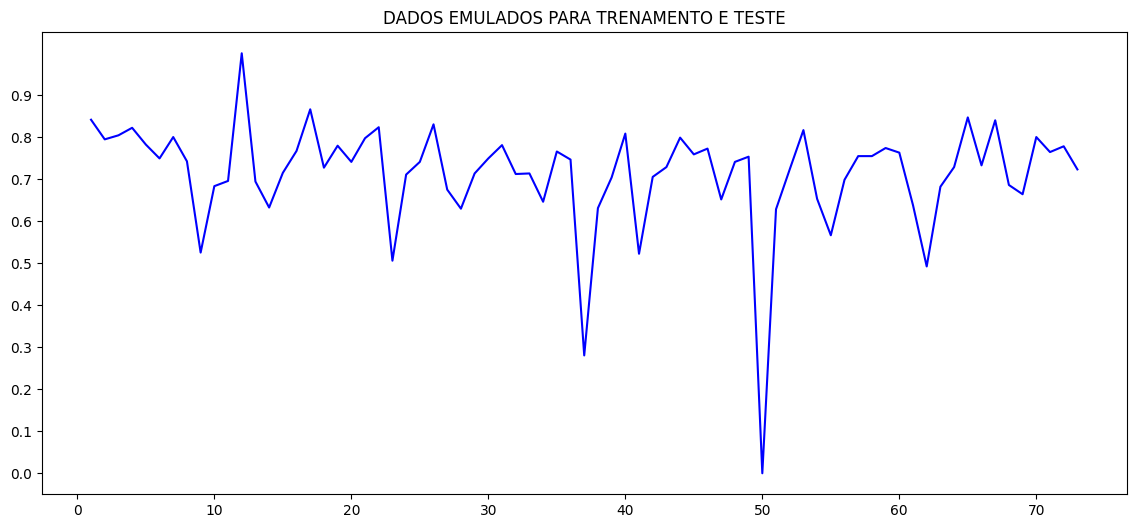

In [96]:
plt.figure(figsize=(14,6))
plt.plot(indice[:-Xis2],train_and_test_consumo_energia_emulado, label="Original", color='blue')
plt.yticks(np.arange(0,1,step=0.1))
plt.title("DADOS EMULADOS PARA TRENAMENTO E TESTE")

Text(0.5, 1.0, 'DADOS EMULADOS PARA VALIDAÇÃO')

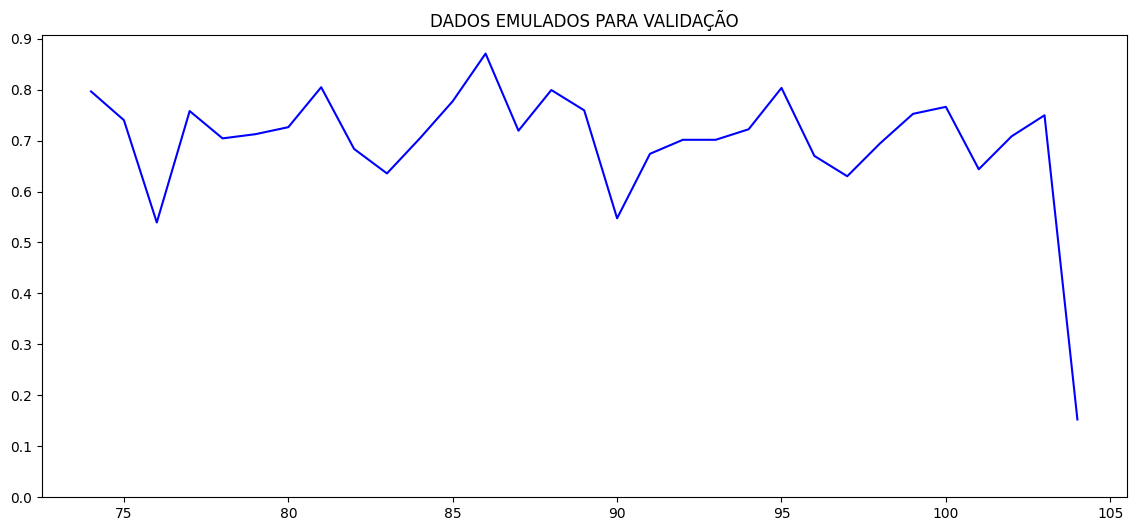

In [97]:
plt.figure(figsize=(14,6))
plt.plot(indice[-Xis2:],validation_consumo_energia_emulado, label="Original", color='blue')
plt.yticks(np.arange(0,1,step=0.1))
plt.title("DADOS EMULADOS PARA VALIDAÇÃO")

In [98]:
##################################################################
## TESTE COM OS DADOS EMULADOS SEM NOVO TREINAMENTO DOS MODELOS ##
##################################################################

C:\Users\renan\AppData\Local\Temp\ipykernel_2916\2771984241.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entrada_lstm_emul = np.array([validation_consumo_energia_emulado.iloc[0][0]])


Shape de validation_consumo_energia_emulado: (31, 1)
Shape de entrada_lstm_emul: (1,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


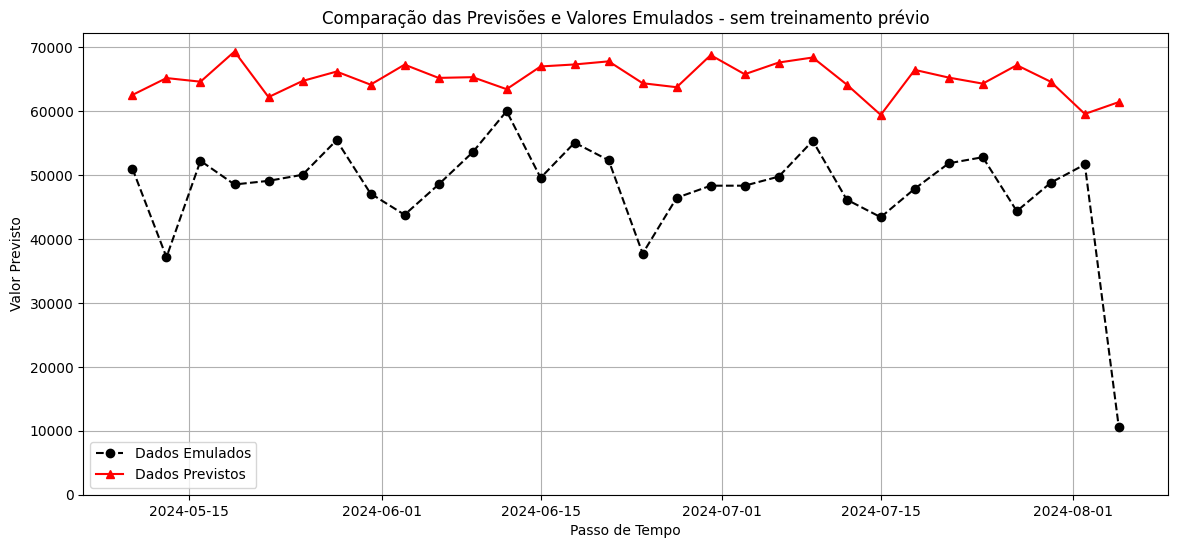

<Figure size 640x480 with 0 Axes>

MAE(Erro absoluto médio) Score of LSTM model =  17222.606
 
MSE(Erro quadrático médio) Score of LSTM model =  362049062.032
 
RMSE(Raiz do erro quadrático médio) Score of LSTM model =  19027.587
 
MAPE(Erro percentual médio absoluto) Score of LSTM model =  0.26
 
2% Accuracy Score of LSTM model =  0.0
5% Accuracy Score of LSTM model =  0.0
10% Accuracy Score of LSTM model =  3.33
 
Erro %. acum 30 dias: 25.86 %
Erro %. acum 60 dias: 25.02 %
Erro %. acum 90 dias: 26.44 %
 
Erro %. acum 1º mês: 25.86 %
Erro %. acum 2º mês: 24.2 %
Erro %. acum 3º mês: 29.33 %
Terminada sequencia de testes


In [99]:
## TESTE 1 - ENSEMBLE MLP (LSTM TL + LSTM CONCAT + LSTM MULTIVAR)

# Obtenção da entrada de validação do modelo ensemble - cada modelo singular recebe a entrada de validação e 
# as saídas 1x30 de cada modelo são concatenadas para servir de entrada para o modelo ensemble

entrada_lstm_emul = np.array([validation_consumo_energia_emulado.iloc[0][0]])
print("Shape de validation_consumo_energia_emulado:", np.array(validation_consumo_energia_emulado).shape)
print("Shape de entrada_lstm_emul:", entrada_lstm_emul.shape)
entrada_lstm_emul = entrada_lstm_emul.reshape(1,1,1) 
entrada_multivar_emul =  np.concatenate((np.array(entrada_lstm_emul), np.array([[[0.4784172]]])), axis=2)
pred_tl_emul = model1.predict(entrada_lstm_emul)
pred_concat_emul = model_2.predict(entrada_lstm_emul[0])
pred_multivar_emul = model_lstm_multivar.predict(entrada_multivar_emul)
lista_combinada_emul = [item for pair in zip(pred_tl_emul, pred_concat_emul, pred_multivar_emul) for item in pair]
concat_preds_alt_emul = np.array(lista_combinada2)

X_val_concat_emul = np.array(concat_preds_alt_emul).reshape(1, -1)  # shape será (1, 90)

pred_emul = model_mlp2.predict(X_val_concat_emul)
y_pred_rescaled_emul = scalers[4].inverse_transform(pred_emul)
y_pred_rescaled_emul = y_pred_rescaled_emul.reshape(-1)  # Converte para 1D, se necessário
validation_consumo_energia_emulado2 = scalers[4].inverse_transform(validation_consumo_energia_emulado[1:])

plt.figure(figsize=(14,6))
plt.plot(duas_unas_validation_scaled[1:].index, validation_consumo_energia_emulado2, label="Dados Emulados", marker='o', linestyle='dashed', color='black')
plt.plot(duas_unas_validation_scaled[1:].index, y_pred_rescaled_emul, label="Dados Previstos", marker='^', linestyle='solid', color='red')
plt.yticks(np.arange(0,80000,step=10000))
plt.title("ENSEMBLE WITH MLP EMUL DATA")

# Criando o gráfico
# plt.figure(figsize=(12, 6))
# plt.plot(duas_unas_validation_rescaled, label='Valores Reais', marker='o', linestyle='dashed', color='black')
# plt.plot(y_pred_ensemble_LSTM_3, label='Ensemble_LSTM_3', marker='s', linestyle='solid', color='blue')
# plt.plot(y_pred_ensemble_MLP_3, label='Ensemble_MLP_3', marker='d', linestyle='solid', color='green')
# plt.plot(y_pred_ensemble_LSTM_2, label='Ensemble_LSTM_2', marker='^', linestyle='solid', color='red')
# plt.plot(y_pred_ensemble_MLP_2, label='Ensemble_MLP_2', marker='p', linestyle='solid', color='orange')

plt.xlabel("Passo de Tempo")
plt.ylabel("Valor Previsto")
plt.legend()
plt.title("Comparação das Previsões e Valores Emulados - sem treinamento prévio")
plt.grid()
plt.show()

# Nome do arquivo incluindo a variável 'validation_method'
file_name = f'prediction_plot_with_MLP_emul_data.png'

# Caminho completo para salvar o arquivo
save_path = os.path.join(diretorio_resultados_ensemble, file_name)

# Salvar o plot
plt.savefig(save_path)
plt.show()

avaliacao_multistep(y_pred_rescaled_emul, validation_consumo_energia_emulado2, diretorio_resultados_ensemble, 'MLP_seq')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


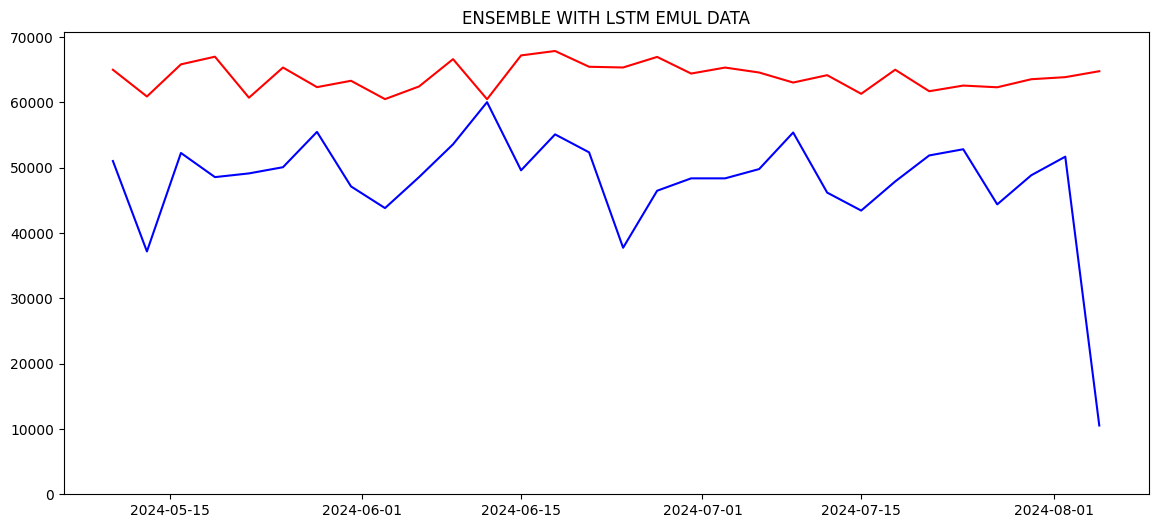

MAE(Erro absoluto médio) Score of LSTM model =  16074.072
 
MSE(Erro quadrático médio) Score of LSTM model =  333428672.39
 
RMSE(Raiz do erro quadrático médio) Score of LSTM model =  18260.029
 
MAPE(Erro percentual médio absoluto) Score of LSTM model =  0.25
 
2% Accuracy Score of LSTM model =  3.33
5% Accuracy Score of LSTM model =  3.33
10% Accuracy Score of LSTM model =  3.33
 
Erro %. acum 30 dias: 23.71 %
Erro %. acum 60 dias: 23.53 %
Erro %. acum 90 dias: 25.12 %
 
Erro %. acum 1º mês: 23.71 %
Erro %. acum 2º mês: 23.36 %
Erro %. acum 3º mês: 28.35 %
Terminada sequencia de testes


In [100]:
## TESTE 2 - ENSEMBLE LSTM (LSTM TL + LSTM CONCAT + LSTM MULTIVAR)

pred_emul2 = model_lstm2.predict(X_val_concat_emul)
y_pred_rescaled_emul2 = scalers[4].inverse_transform(pred_emul2)
y_pred_rescaled_emul2 = y_pred_rescaled_emul2.reshape(-1)  # Converte para 1D, se necessário
validation_consumo_energia_emulado2 = scalers[4].inverse_transform(validation_consumo_energia_emulado[1:])

plt.figure(figsize=(14,6))
plt.plot(duas_unas_validation_scaled[1:].index, validation_consumo_energia_emulado2, label="Original", color='blue')
plt.plot(duas_unas_validation_scaled[1:].index, y_pred_rescaled_emul2, label="Predict", color='red')
plt.yticks(np.arange(0,80000,step=10000))
plt.title("ENSEMBLE WITH LSTM EMUL DATA")

# Nome do arquivo incluindo a variável 'validation_method'
file_name = f'prediction_plot_with_LSTM_emul_data.png'

# Caminho completo para salvar o arquivo
save_path = os.path.join(diretorio_resultados_ensemble, file_name)

# Salvar o plot
plt.savefig(save_path)
plt.show()

avaliacao_multistep(y_pred_rescaled_emul2, validation_consumo_energia_emulado2, diretorio_resultados_ensemble, 'MLP_seq')

In [101]:
##################################################################
## TESTE COM OS DADOS EMULADOS COM NOVO TREINAMENTO DOS MODELOS ##
##################################################################

In [102]:
def create_dataset_emulado(data, time_step, output_steps):
    X, y = [], []
    # Verifica se `data` é um DataFrame ou Series do pandas
    if isinstance(data, pd.Series):
        data = data.values.reshape(-1, 1)  # Converta para array NumPy e ajuste dimensões
    elif isinstance(data, pd.DataFrame):
        data = data.values  # Converta para array NumPy
        
    for i in range(len(data) - time_step - output_steps + 1):
        X.append(data[i:(i + time_step), :])  # Use indexação NumPy
        y.append(data[(i + time_step):(i + time_step + output_steps), 0])  # Prevendo com base na primeira variável
    return np.array(X), np.array(y)


def create_dataset_multivar_emulado(data, time_step, output_steps):
    X, y = [], []
    for i in range(len(data) - time_step - output_steps + 1):
        X.append(data[i:(i + time_step), :])  # Use indexação NumPy
        y.append(data[(i + time_step):(i + time_step + output_steps), 0])  # Prevendo com base na primeira variável
    return np.array(X), np.array(y)

In [103]:
# Criação das entradas e saídas dos modelos singelos
X_emul, y_emul = create_dataset_emulado(train_and_test_consumo_energia_emulado, timesteps, output_steps)
X_emul = X_emul.reshape(X_emul.shape[0], X_emul.shape[1], 1)

print(f"X_emul",X_emul.shape)
print(f"y_emul:",y_emul.shape)

X_emul (43, 1, 1)
y_emul: (43, 30)


In [104]:
dataset_multivar_emul = np.stack([train_and_test_consumo_energia_emulado, nivel_agua_train[:(train_and_test_consumo_energia_emulado.shape[0])]], axis=-1) # Preparar os 2 recursos de entrada para o formato correto

# Chamada da função
X_multivar_emul, y_multivar_emul = create_dataset_multivar_emulado(dataset_multivar_emul, timesteps, output_steps)
X_multivar_emul = X_multivar_emul.reshape(X_multivar_emul.shape[0], X_multivar_emul.shape[1], 2)

print(f"X_multivar_emul:",X_multivar_emul.shape)
print(f"y_multivar_emul:",y_multivar_emul.shape)

X_multivar_emul: (43, 1, 2)
y_multivar_emul: (43, 30, 2)


In [105]:
# Obtenção das saídas dos 3 modelos singelos que servirão de treinamento do MLP

lstm_tl_pred_emul = model1.predict(X_emul)
lstm_concat_pred_emul = []
for i in range(0,X_emul.shape[0]):
    lstm_concat_pred_emul.append(model_2.predict(X_emul[i]))
    
lstm_concat_pred_emul = np.array(lstm_concat_pred_emul)
lstm_concat_pred_emul = lstm_concat_pred_emul.reshape(43,30)
lstm_multivar_pred_emul = model_lstm_multivar.predict(X_multivar_emul)

print(lstm_tl_pred_emul.shape)
print(lstm_concat_pred_emul.shape)
print(lstm_multivar_pred_emul.shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━

In [106]:
# Cria um novo dataset com as saídas dos modelos [1x30], [1x30], [1x30], alternando os elementos de cada lista para gerar a nova lista [1x90]
concat_preds_alt_emul = []
for i in range(0, len(lstm_concat_pred_emul)):    
    pred_lstm_tl_to_concat_emul = lstm_tl_pred_emul[i]
    pred_lstm_concat_to_concat_emul = lstm_concat_pred_emul[i]
    pred_lstm_multivar_to_concat_emul = lstm_multivar_pred_emul[i]
    lista_combinada_emul = [item for pair in zip(pred_lstm_tl_to_concat_emul, pred_lstm_concat_to_concat_emul, pred_lstm_multivar_to_concat_emul) for item in pair]
    concat_preds_alt_emul.append(lista_combinada_emul)
#print(concat_preds)
concat_preds_alt_emul = np.array(concat_preds_alt_emul)
print(concat_preds_alt_emul.shape)

(43, 90)


In [107]:
X_train_emul, X_test_emul, y_train_emul, y_test_emul = train_test_split(concat_preds_alt_emul, y_emul, test_size=0.9, random_state=42)
print(f"X_train_emul",X_train_emul.shape)
print(f"y_train_emul:",y_train_emul.shape)
print(f"X_test_emul",X_test_emul.shape)
print(f"y_test_emul:",y_test_emul.shape)

X_train_emul (4, 90)
y_train_emul: (4, 30)
X_test_emul (39, 90)
y_test_emul: (39, 30)


Epoch 1/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - loss: 0.2451 - val_loss: 0.1171
Epoch 2/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1052 - val_loss: 0.1202
Epoch 3/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1127 - val_loss: 0.1124
Epoch 4/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1030 - val_loss: 0.1334
Epoch 5/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.1208 - val_loss: 0.1500
Epoch 6/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.1264 - val_loss: 0.1266
Epoch 7/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1050 - val_loss: 0.1402
Epoch 8/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1250 - val_loss: 0.1595
Epoch 9/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.1490 - val_loss: 0.1530
Epoch 10/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1404 - val_loss: 0.1349
Epoch 11/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1156 - val_loss: 0.1306
Epoch 11: early stopping
Restoring model 

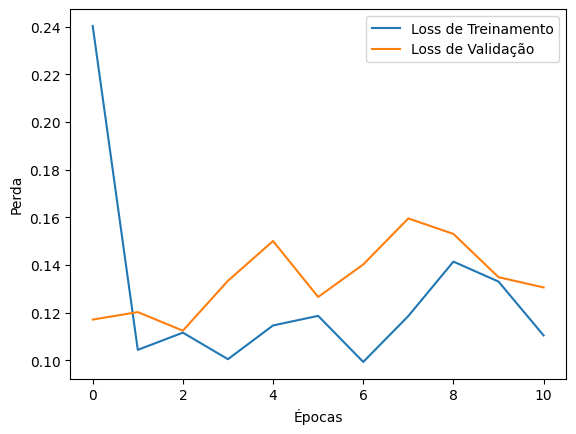

In [108]:
## TESTE 3 - Treinamento do modelo Ensemble MLP com os dados emulados (ajuste fino)

ensemble_model_mlp = model_mlp2
# Definindo o otimizador com a taxa de aprendizado
optimizer = RMSprop(learning_rate=0.0009)

# Compilando o modelo
ensemble_model_mlp.compile(loss=wmae, optimizer=optimizer)

early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=8, restore_best_weights=True)

# Treinando o modelo
history = ensemble_model_mlp.fit(X_train_emul, y_train_emul, epochs=10000, batch_size=3, validation_data=(X_test_emul, y_test_emul), callbacks=[early_stopping])

# Plotar as perdas de treinamento e validação
plt.plot(history.history['loss'], label='Loss de Treinamento')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

Shape de validation_consumo_energia_emulado: (31, 1)
Shape de entrada_lstm_emul: (1,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


C:\Users\renan\AppData\Local\Temp\ipykernel_2916\2786685539.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entrada_lstm_emul = np.array([validation_consumo_energia_emulado.iloc[0][0]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


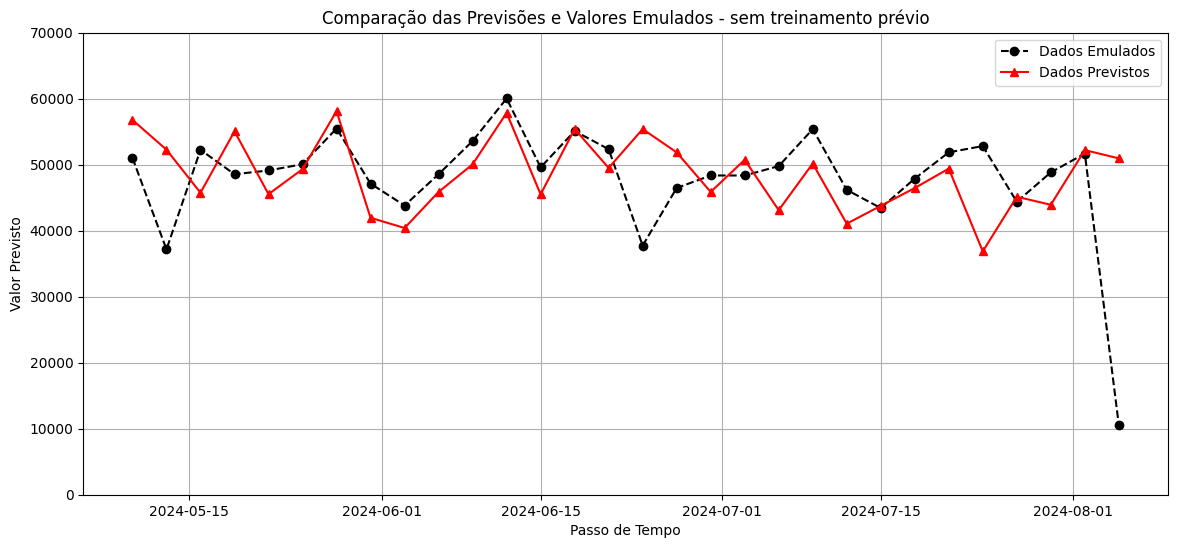

<Figure size 640x480 with 0 Axes>

MAE(Erro absoluto médio) Score of LSTM model =  5893.351
 
MSE(Erro quadrático médio) Score of LSTM model =  94239585.068
 
RMSE(Raiz do erro quadrático médio) Score of LSTM model =  9707.708
 
MAPE(Erro percentual médio absoluto) Score of LSTM model =  0.12
 
2% Accuracy Score of LSTM model =  16.67
5% Accuracy Score of LSTM model =  33.33
10% Accuracy Score of LSTM model =  56.67
 
Erro %. acum 30 dias: 1.61 %
Erro %. acum 60 dias: 1.19 %
Erro %. acum 90 dias: 1.29 %
 
Erro %. acum 1º mês: 1.61 %
Erro %. acum 2º mês: 0.78 %
Erro %. acum 3º mês: 1.51 %
Terminada sequencia de testes


In [109]:
# Obtenção da entrada de validação do modelo ensemble - cada modelo singular recebe a entrada de validação e 
# as saídas 1x30 de cada modelo são concatenadas para servir de entrada para o modelo ensemble
entrada_lstm_emul = np.array([validation_consumo_energia_emulado.iloc[0][0]])
print("Shape de validation_consumo_energia_emulado:", np.array(validation_consumo_energia_emulado).shape)
print("Shape de entrada_lstm_emul:", entrada_lstm_emul.shape)
entrada_lstm_emul = entrada_lstm_emul.reshape(1,1,1) 
#print(entrada_lstm_emul[0][0][0])
entrada_multivar_emul =  np.concatenate((np.array(entrada_lstm_emul), np.array([[[0.4784172]]])), axis=2)
pred_tl_emul = model1.predict(entrada_lstm_emul)
pred_concat_emul = model_2.predict(entrada_lstm_emul[0])
pred_multivar_emul = model_lstm_multivar.predict(entrada_multivar_emul)
lista_combinada_emul = [item for pair in zip(pred_tl_emul, pred_concat_emul, pred_multivar_emul) for item in pair]
concat_preds_alt_emul = np.array(lista_combinada2)

X_val_concat_emul = np.array(concat_preds_alt_emul).reshape(1, -1)  # shape será (1, 90)

pred_emul = ensemble_model_mlp.predict(X_val_concat_emul)
y_pred_rescaled_emul = scalers[4].inverse_transform(pred_emul)
y_pred_rescaled_emul = y_pred_rescaled_emul.reshape(-1)  # Converte para 1D, se necessário
validation_consumo_energia_emulado2 = scalers[4].inverse_transform(validation_consumo_energia_emulado[1:])


plt.figure(figsize=(14,6))
plt.plot(duas_unas_validation_scaled[1:].index, validation_consumo_energia_emulado2, label="Dados Emulados", marker='o', linestyle='dashed', color='black')
plt.plot(duas_unas_validation_scaled[1:].index, y_pred_rescaled_emul, label="Dados Previstos", marker='^', linestyle='solid', color='red')
plt.yticks(np.arange(0,80000,step=10000))
plt.title("ENSEMBLE WITH MLP EMUL DATA")

# Criando o gráfico
# plt.figure(figsize=(12, 6))
# plt.plot(duas_unas_validation_rescaled, label='Valores Reais', marker='o', linestyle='dashed', color='black')
# plt.plot(y_pred_ensemble_LSTM_3, label='Ensemble_LSTM_3', marker='s', linestyle='solid', color='blue')
# plt.plot(y_pred_ensemble_MLP_3, label='Ensemble_MLP_3', marker='d', linestyle='solid', color='green')
# plt.plot(y_pred_ensemble_LSTM_2, label='Ensemble_LSTM_2', marker='^', linestyle='solid', color='red')
# plt.plot(y_pred_ensemble_MLP_2, label='Ensemble_MLP_2', marker='p', linestyle='solid', color='orange')

plt.xlabel("Passo de Tempo")
plt.ylabel("Valor Previsto")
plt.legend()
plt.title("Comparação das Previsões e Valores Emulados - sem treinamento prévio")
plt.grid()
plt.show()



# plt.figure(figsize=(14,6))
# plt.plot(duas_unas_validation_scaled[1:].index, validation_consumo_energia_emulado2, label="Original", color='blue')
# plt.plot(duas_unas_validation_scaled[1:].index, y_pred_rescaled_emul, label="Predict", color='red')
# plt.yticks(np.arange(0,80000,step=10000))
# plt.title("ENSEMBLE WITH MLP EMUL DATA TRAINED MODEL")

# Nome do arquivo incluindo a variável 'validation_method'
file_name = f'prediction_plot_with_MLP_emul_data_trained_model.png'

# Caminho completo para salvar o arquivo
save_path = os.path.join(diretorio_resultados_ensemble, file_name)

# Salvar o plot
plt.savefig(save_path)
plt.show()

avaliacao_multistep(y_pred_rescaled_emul, validation_consumo_energia_emulado2, diretorio_resultados_ensemble, 'MLP_seq')

Epoch 1/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 734ms/step - loss: 0.2952 - val_loss: 0.0972
Epoch 2/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1832 - val_loss: 0.1163
Epoch 3/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.1714 - val_loss: 0.0970
Epoch 4/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 0.1609 - val_loss: 0.1228
Epoch 5/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.1503 - val_loss: 0.1562
Epoch 6/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.2021 - val_loss: 0.0952
Epoch 7/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.1685 - val_loss: 0.1143
Epoch 8/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.1671 - val_loss: 0.1002
Epoch 9/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1546 - val_loss: 0.1139
Epoch 10/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1558 - val_loss: 0.0932
Epoch 11/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step - loss: 0.1682 - val_loss: 0.0950
Epoch 12/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1

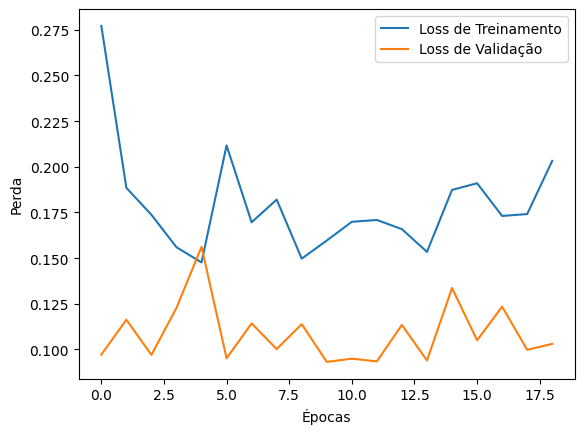

In [110]:
## TESTE 4 - Treinamento do modelo Ensemble LSTM com os dados emulados (ajuste fino)

ensemble_model_lstm = model_lstm2

# Definindo o otimizador com a taxa de aprendizado
optimizer = RMSprop(learning_rate=0.001)

# Compilando o modelo
ensemble_model_lstm.compile(loss=wmae, optimizer=optimizer)

early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=9, restore_best_weights=True)

# Treinando o modelo
history = ensemble_model_lstm.fit(X_train_emul, y_train_emul, epochs=10000, batch_size=2, validation_data=(X_test_emul, y_test_emul), callbacks=[early_stopping])

# Plotar as perdas de treinamento e validação
plt.plot(history.history['loss'], label='Loss de Treinamento')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


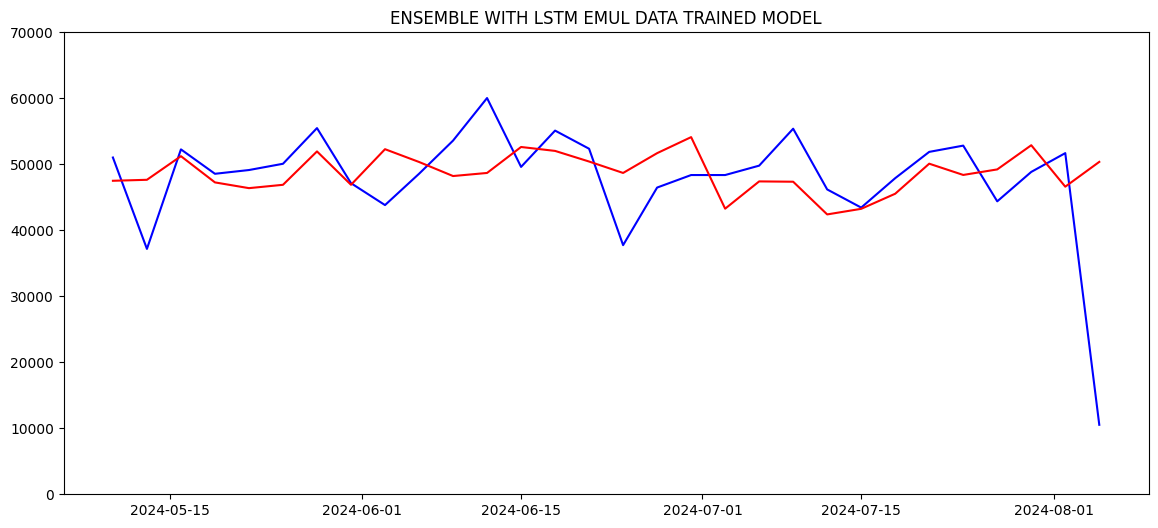

MAE(Erro absoluto médio) Score of LSTM model =  5494.023
 
MSE(Erro quadrático médio) Score of LSTM model =  79376493.184
 
RMSE(Raiz do erro quadrático médio) Score of LSTM model =  8909.349
 
MAPE(Erro percentual médio absoluto) Score of LSTM model =  0.11
 
2% Accuracy Score of LSTM model =  6.67
5% Accuracy Score of LSTM model =  23.33
10% Accuracy Score of LSTM model =  63.33
 
Erro %. acum 30 dias: 1.06 %
Erro %. acum 60 dias: 0.09 %
Erro %. acum 90 dias: 1.63 %
 
Erro %. acum 1º mês: 1.06 %
Erro %. acum 2º mês: 0.87 %
Erro %. acum 3º mês: 4.84 %
Terminada sequencia de testes


In [111]:
pred_emul2 = ensemble_model_lstm.predict(X_val_concat_emul)
y_pred_rescaled_emul2 = scalers[4].inverse_transform(pred_emul2)
y_pred_rescaled_emul2 = y_pred_rescaled_emul2.reshape(-1)  # Converte para 1D, se necessário
validation_consumo_energia_emulado2 = scalers[4].inverse_transform(validation_consumo_energia_emulado[1:])

plt.figure(figsize=(14,6))
plt.plot(duas_unas_validation_scaled[1:].index, validation_consumo_energia_emulado2, label="Original", color='blue')
plt.plot(duas_unas_validation_scaled[1:].index, y_pred_rescaled_emul2, label="Predict", color='red')
plt.yticks(np.arange(0,80000,step=10000))
plt.title("ENSEMBLE WITH LSTM EMUL DATA TRAINED MODEL")

# Nome do arquivo incluindo a variável 'validation_method'
file_name = f'prediction_plot_with_LSTM_emul_data_trained_model.png'

# Caminho completo para salvar o arquivo
save_path = os.path.join(diretorio_resultados_ensemble, file_name)

# Salvar o plot
plt.savefig(save_path)
plt.show()

avaliacao_multistep(y_pred_rescaled_emul2, validation_consumo_energia_emulado2, diretorio_resultados_ensemble, 'MLP_seq')